## ✈ **Set Up Google Colab (No Actions Needed)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.compose import ColumnTransformer
from scipy.sparse import csr_matrix, hstack, vstack

!pip install category_encoders
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

np.random.seed(4012)
url="https://raw.githubusercontent.com/minghan101/BT4012/refs/heads/main/fake_job_postings.csv"
df = pd.read_csv(url)
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 6.9 MB/s eta 0:00:00


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


# **1. Exploratory Data Analysis (EDA) & Data Cleaning**

- **Data Overview**: Load and inspect dataset structure.
- **Visualization**:
  - **Numeric Columns**: Histograms, boxplots, correlation heatmap.
  - **Categorical Columns**: Bar plots, class distributions (e.g., `fraudulent` label).
- **Column Separation**:
  - Split comma-delimited columns (e.g., `location`) into structured features.
- **Missing Values**: Identify and handle missing entries.
---

## **1.1. Exploratory Data Analysis (EDA)**

In [ ]:
# Check class balance
print("\nFraudulent vs Real:")
print(df['fraudulent'].value_counts())
print("\nFraud percentage: {:.2f}%".format(df['fraudulent'].mean() * 100))

'''
The dataset is highly imbalanced. This means that the model may be biased towards predicting "non-fraud" unless we address the imbalance later via resampling or class weighting.
'''


Fraudulent vs Real:
fraudulent
0    17014
1      866
Name: count, dtype: int64

Fraud percentage: 4.84%


'\nThe dataset is highly imbalanced. This means that the model may be biased towards predicting "non-fraud" unless we address the imbalance later via resampling or class weighting.\n'

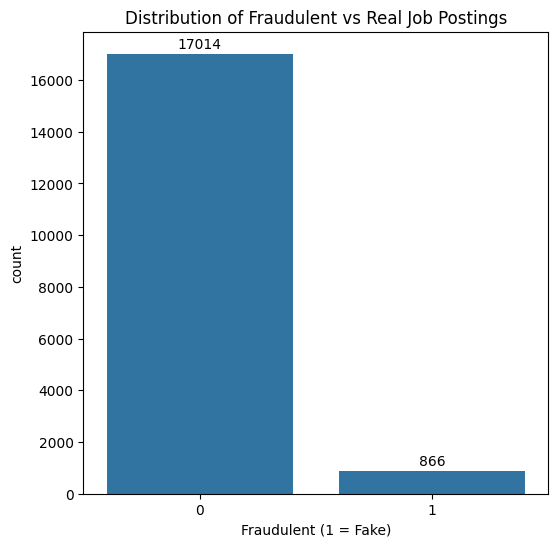

In [ ]:
# Plot target distribution
plt.figure(figsize=(6, 6))
ax = sns.countplot(data=df, x='fraudulent')
plt.title('Distribution of Fraudulent vs Real Job Postings')
plt.xlabel('Fraudulent (1 = Fake)')

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10, padding=2)

plt.show()

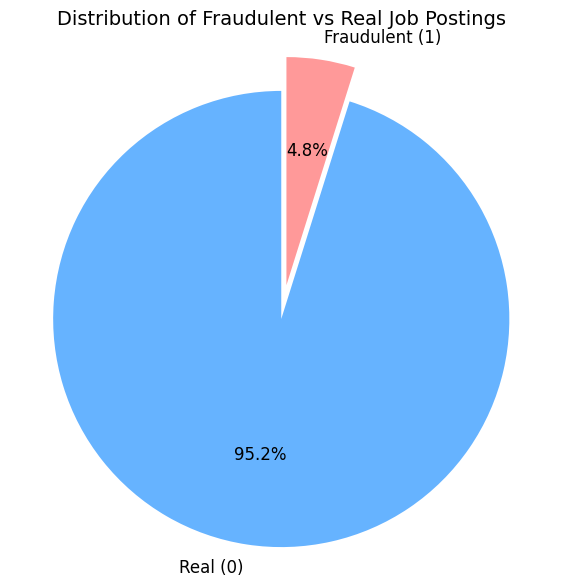

In [ ]:
# Plot target distribution as a pie chart
fraud_counts = df['fraudulent'].value_counts()
labels = ['Real (0)', 'Fraudulent (1)']
sizes = fraud_counts.values
colors = ['#66b3ff', '#ff9999']  # blue for real, red for fake
explode = (0.05, 0.1)  # slightly explode both slices for emphasis

plt.figure(figsize=(7, 7))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=explode,
    textprops={'fontsize': 12}
)
plt.title('Distribution of Fraudulent vs Real Job Postings', fontsize=14)
plt.axis('equal')  # ensures pie is circular
plt.show()

In [ ]:
# Missing data summary
missing = df.isnull().sum()
missing_pct = 100 * missing / len(df)

missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
}).sort_values(by='Missing %', ascending=False)

print("Top columns with missing values:")
print(missing_df[missing_df['Missing Count'] > 0])

'''
text-heavy columns have a lot of missing values. like salary_range, department, required_education etc.
real company will usually specify at least employment type, experience level, and whether benefits are offered.
scammer often leaves these blank to stay generic.
Can put in Feature Engineering

'''

Top columns with missing values:
                     Missing Count  Missing %
salary_range                 15012  83.959732
department                   11547  64.580537
required_education            8105  45.329978
benefits                      7212  40.335570
required_experience           7050  39.429530
function                      6455  36.101790
industry                      4903  27.421700
employment_type               3471  19.412752
company_profile               3308  18.501119
requirements                  2696  15.078300
location                       346   1.935123
description                      1   0.005593


'\ntext-heavy columns have a lot of missing values. like salary_range, department, required_education etc.\nreal company will usually specify at least employment type, experience level, and whether benefits are offered.\nscammer often leaves these blank to stay generic.\nCan put in Feature Engineering\n\n'

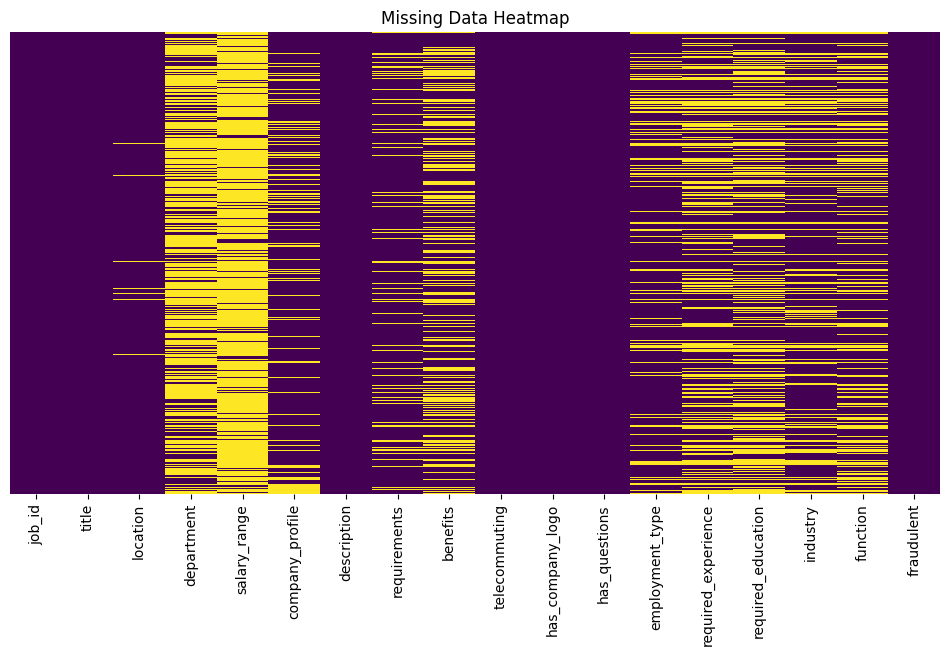

In [ ]:
# Visualize missingness
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

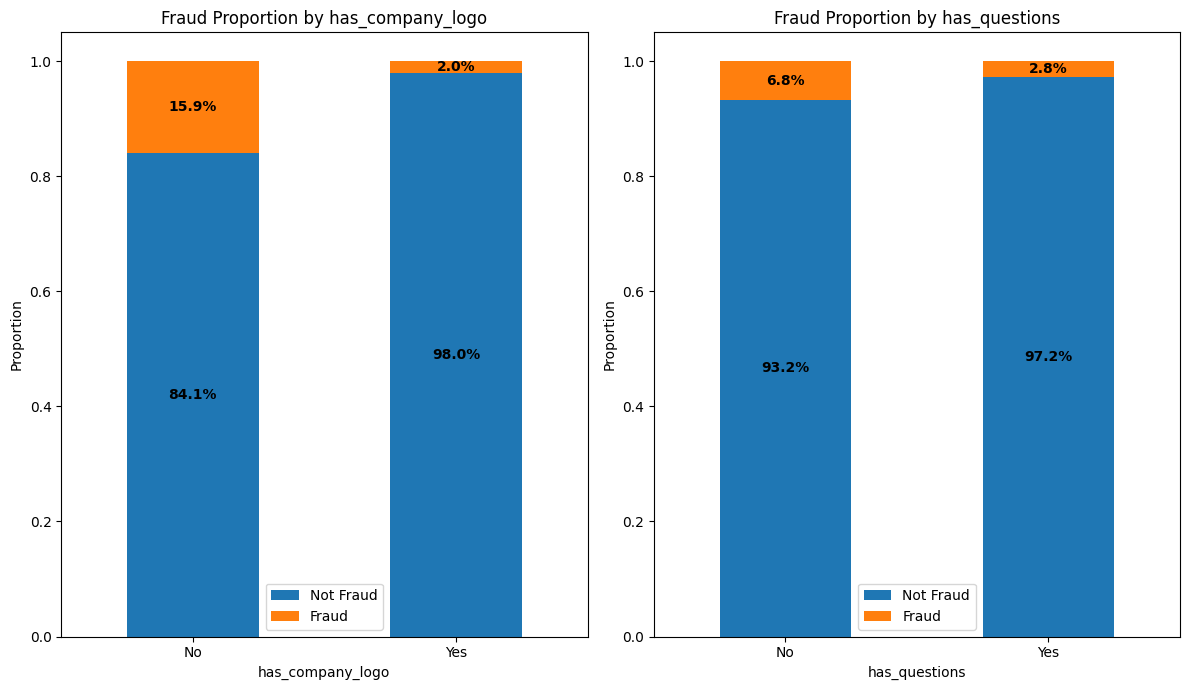

'\n\nCan do pie chart & account for diff in sample size for viz ## MH FOLLOW UP\n\nReal Jobs (Blue) mostly have logos, while fake jobs (Orange) almost never have logos. Scammers avoid logos because they don’t have real companies to represent\nFaudulent jobs tend to have greater proportion of jobs without  company logos.\n\nReal Jobs (blue) mostly often ask screening questions but fake jobs (orange) rarely ask questions. scammers just want you to apply blindly\n\n'

In [ ]:
# ANALYSE KEY METADATA FEATURES
# has_company_logo and has_questions - fake jobs often lack company logos and don’t ask questions
# Compute fraud rate per category
cols = ['has_company_logo', 'has_questions']
fig, axes = plt.subplots(1, 2, figsize=(12, 7))

for i, col in enumerate(cols):
    # Group by column and fraudulent, then normalize to get proportions
    prop = df.groupby(col)['fraudulent'].value_counts(normalize=True).unstack().fillna(0)
    # Ensure both 0 and 1 are present as columns
    for val in [0, 1]:
        if val not in prop.columns:
            prop[val] = 0
    prop = prop[[0, 1]]  # Order: real (0), fake (1)

    # Plot stacked bar
    prop.plot(kind='bar', stacked=True, ax=axes[i], color=['#1f77b4', '#ff7f0e'])
    axes[i].set_title(f'Fraud Proportion by {col}')
    axes[i].set_ylabel('Proportion')
    axes[i].set_xlabel(col)
    axes[i].legend(['Not Fraud', 'Fraud'])
    axes[i].tick_params(axis='x', rotation=0)
    axes[i].set_xticklabels(['No', 'Yes'])

    # Annotate % of fake jobs on top of each bar
    for j, (idx, row) in enumerate(prop.iterrows()):
        real_pct = row[0] * 100
        axes[i].text(j, row[0] / 2, f'{real_pct:.1f}%', ha='center', va='center', color='black', fontweight='bold')

        fake_pct = row[1] * 100
        axes[i].text(j, row[0] + row[1] / 2, f'{fake_pct:.1f}%', ha='center', va='center', color='black', fontweight='bold')

plt.tight_layout()
plt.show()

'''

Can do pie chart & account for diff in sample size for viz ## MH FOLLOW UP

Real Jobs (Blue) mostly have logos, while fake jobs (Orange) almost never have logos. Scammers avoid logos because they don’t have real companies to represent
Faudulent jobs tend to have greater proportion of jobs without  company logos.

Real Jobs (blue) mostly often ask screening questions but fake jobs (orange) rarely ask questions. scammers just want you to apply blindly

'''

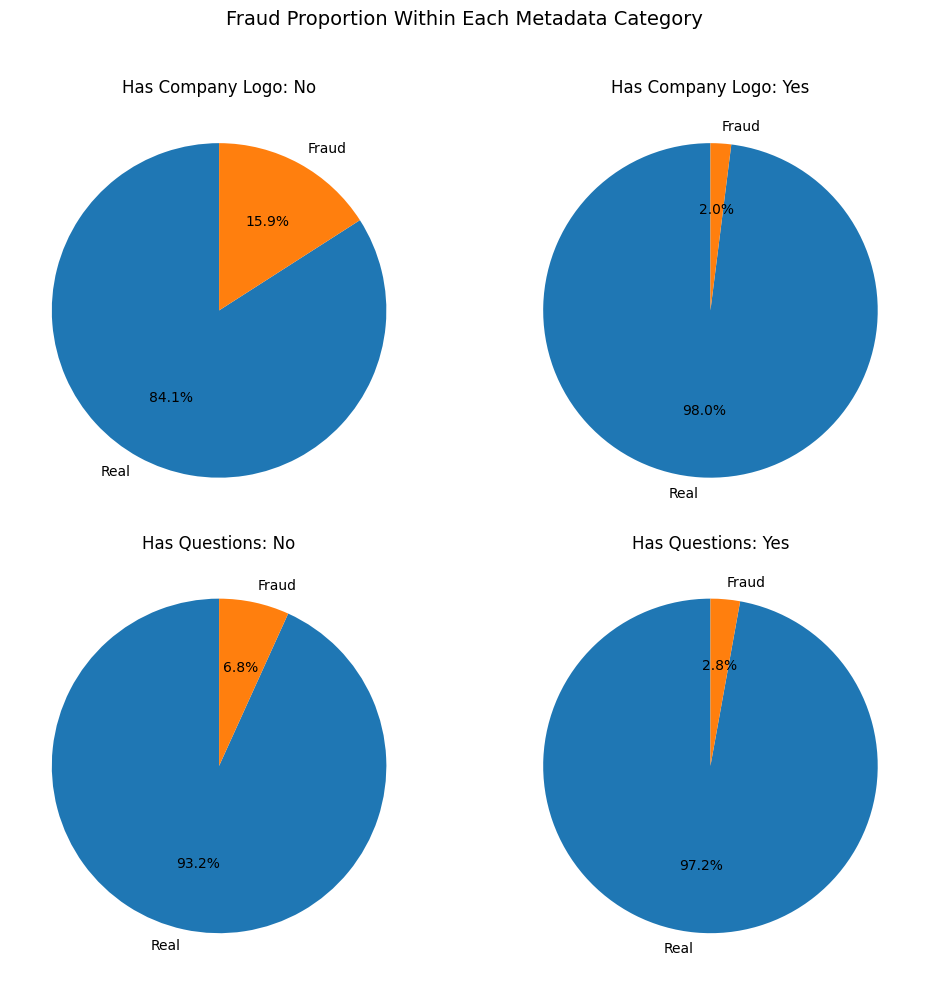

In [ ]:
import matplotlib.pyplot as plt

cols = ['has_company_logo', 'has_questions']
fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 2 features × 2 pies each = 4 subplots

for i, col in enumerate(cols):
    # Get fraud rate per category (0 = No, 1 = Yes)
    fraud_by_group = df.groupby(col)['fraudulent'].value_counts(normalize=True).unstack(fill_value=0)

    # Ensure columns 0 (real) and 1 (fraud) exist
    for label in [0, 1]:
        if label not in fraud_by_group.columns:
            fraud_by_group[label] = 0
    fraud_by_group = fraud_by_group[[0, 1]]

    # Labels for "No" and "Yes" in the feature
    categories = ['No', 'Yes']  # corresponds to col=0 and col=1

    for j, cat in enumerate(categories):
        group_fraud_rates = fraud_by_group.loc[j]  # j = 0 → "No", j = 1 → "Yes"
        sizes = [group_fraud_rates[0], group_fraud_rates[1]]  # [real%, fraud%]
        labels = ['Real', 'Fraud']
        colors = ['#1f77b4', '#ff7f0e']

        wedges, texts, autotexts = axes[i, j].pie(
            sizes,
            labels=labels,
            colors=colors,
            autopct='%1.1f%%',
            startangle=90,
            textprops={'fontsize': 10}
        )
        axes[i, j].set_title(f'{col.replace("_", " ").title()}: {cat}')

plt.suptitle('Fraud Proportion Within Each Metadata Category', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

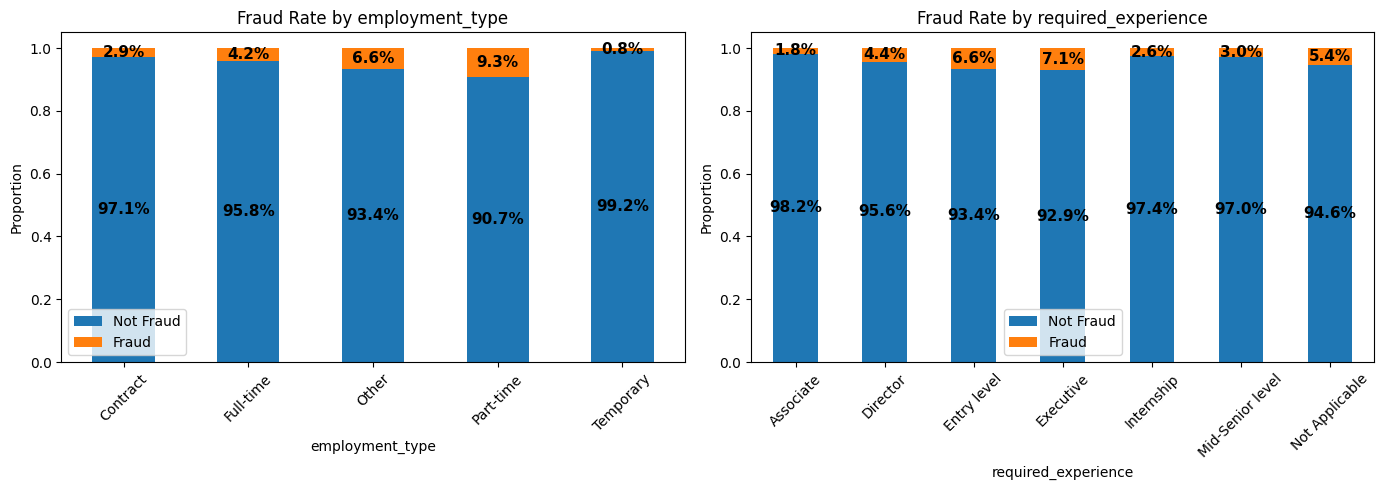

'\nfraud rate by required_experience\nwhat it shows is for each experience level (entry level, director, etc.) what % of postings are fake.\nfraud is rare in all categories as the orange bar is small everywhere.\nnot applicable and internship roles have slightly higher fraud rates but still under 10%.\n\nExperience level also doesn’t strongly predict fraud but scammers might slightly prefer entry-level or vague “not applicable” roles.\n'

In [ ]:
# employment_type and required_experience
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, col in enumerate(['employment_type', 'required_experience']):
    temp = df.groupby([col, 'fraudulent']).size().unstack(fill_value=0)
    temp_pct = temp.div(temp.sum(axis=1), axis=0)  # normalize per category
    temp_pct.plot(kind='bar', stacked=True, ax=axes[i])
    axes[i].set_title(f'Fraud Rate by {col}')
    axes[i].set_ylabel('Proportion')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(['Not Fraud', 'Fraud'])

    for j, (idx, row) in enumerate(temp_pct.iterrows()):
        real_pct = row[0] * 100
        fake_pct = row[1] * 100

        # Label inside blue (Not Fraud)
        axes[i].text(j, row[0] / 2, f'{real_pct:.1f}%', ha='center', va='center', color='black', fontsize=11, fontweight='bold')

        # Label inside orange (Fraud)
        axes[i].text(j, row[0] + row[1] / 2, f'{fake_pct:.1f}%', ha='center', va='center', color='black', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

'''
how to interpret the graphs:
what it shows is for each job type (contract, full-time, etc.), what % of postings are fake and real
All job types have very low fraud rates. the orange bar (fraudulent = 1) is tiny in every category.
Temporary jobs have the lowest fraud rate, part-time and contract jobs have slightly higher fraud than others but still very low overall (<5%).
conclusion: job type alone isn’t a strong predictor of fraud, most fake jobs are spread across all employment types.
'''

'''
fraud rate by required_experience
what it shows is for each experience level (entry level, director, etc.) what % of postings are fake.
fraud is rare in all categories as the orange bar is small everywhere.
not applicable and internship roles have slightly higher fraud rates but still under 10%.

Experience level also doesn’t strongly predict fraud but scammers might slightly prefer entry-level or vague “not applicable” roles.
'''

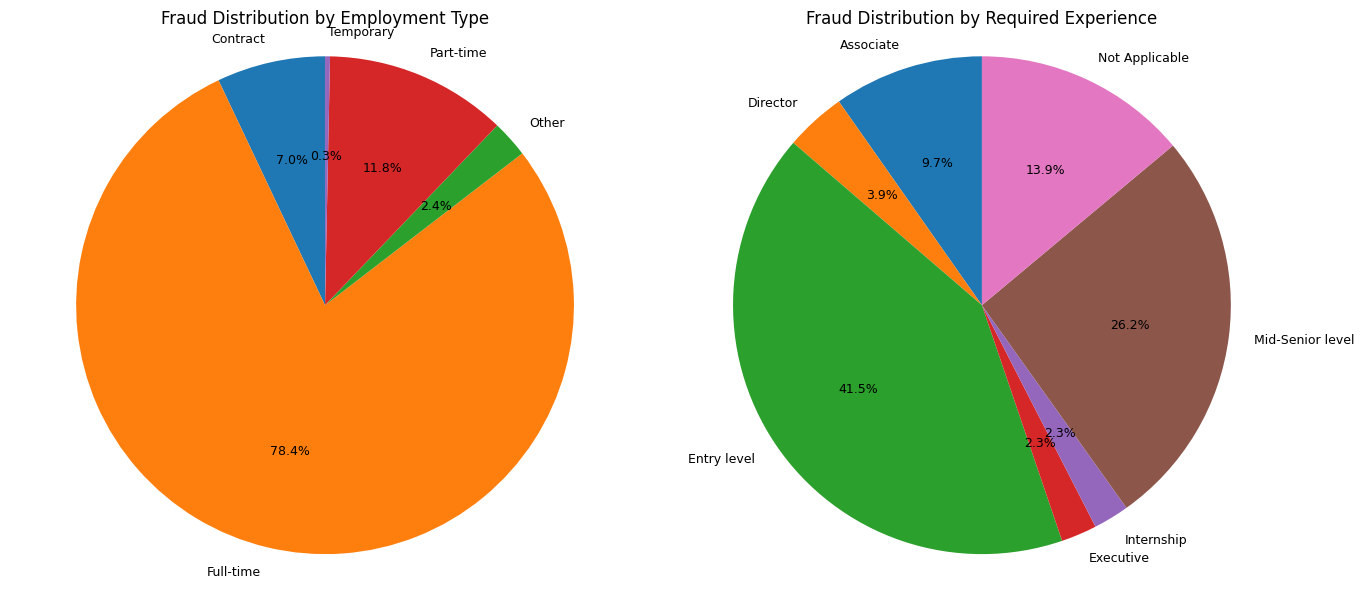

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Define colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

for i, col in enumerate(['employment_type', 'required_experience']):
    # Filter only fraudulent jobs
    fraud_only = df[df['fraudulent'] == 1]

    # Count fraud per category
    counts = fraud_only[col].value_counts().sort_index()

    # Plot pie
    wedges, texts, autotexts = axes[i].pie(
        counts.values,
        labels=counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors[:len(counts)],
        textprops={'fontsize': 9}
    )
    axes[i].set_title(f'Fraud Distribution by {col.replace("_", " ").title()}', fontsize=12)
    axes[i].axis('equal')  # Equal aspect ratio ensures that pies are circular.

plt.tight_layout()
plt.show()

## **1.2. Data Cleaning**

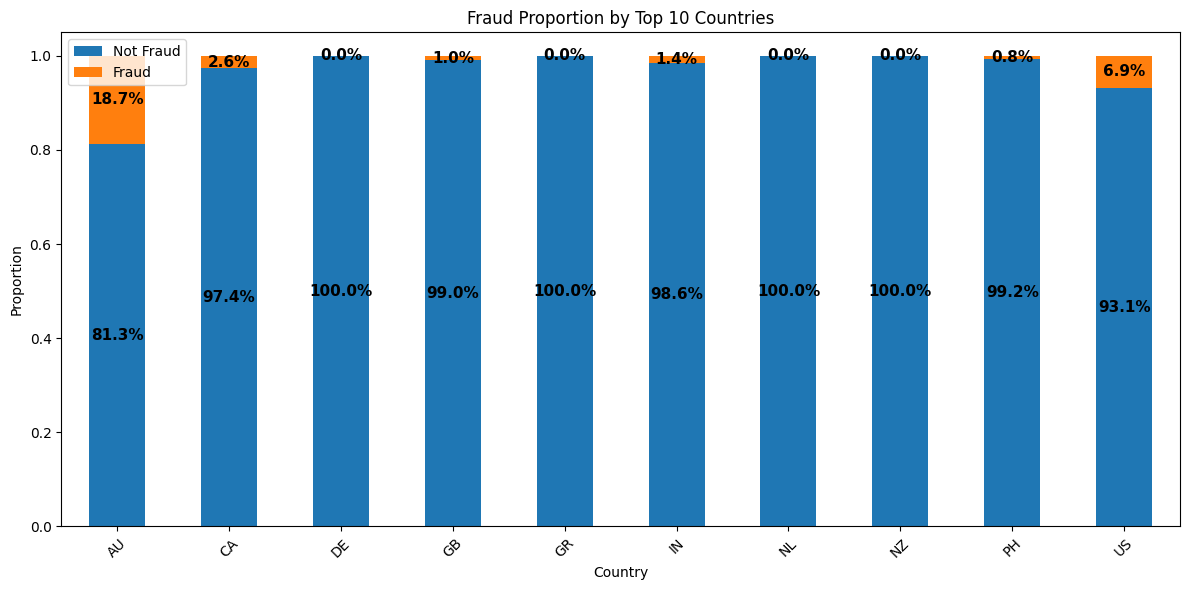

In [ ]:
# Extract country
df['country'] = df['location'].str.split(',').str[0]

# Top 10 countries by total count
top_countries = df['country'].value_counts().head(10).index
df_top = df[df['country'].isin(top_countries)]

# Compute fraud proportion per country
prop = df_top.groupby('country')['fraudulent'].value_counts(normalize=True).unstack(fill_value=0)
# Ensure both 0 and 1 are present
for val in [0, 1]:
    if val not in prop.columns:
        prop[val] = 0
prop = prop[[0, 1]]  # Order: Real (0), Fake (1)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
prop.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], ax=ax)
ax.set_title('Fraud Proportion by Top 10 Countries')
ax.set_ylabel('Proportion')
ax.set_xlabel('Country')
ax.legend(['Not Fraud', 'Fraud'])
ax.tick_params(axis='x', rotation=45)

# Annotate % of fake jobs on each bar
for j, (country, row) in enumerate(prop.iterrows()):
    real_pct = row[0] * 100
    fake_pct = row[1] * 100

    # Label inside blue (Not Fraud)
    ax.text(j, row[0] / 2, f'{real_pct:.1f}%', ha='center', va='center', color='black', fontsize=11, fontweight='bold')

    # Label inside orange (Fraud)
    ax.text(j, row[0] + row[1] / 2, f'{fake_pct:.1f}%', ha='center', va='center', color='black', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

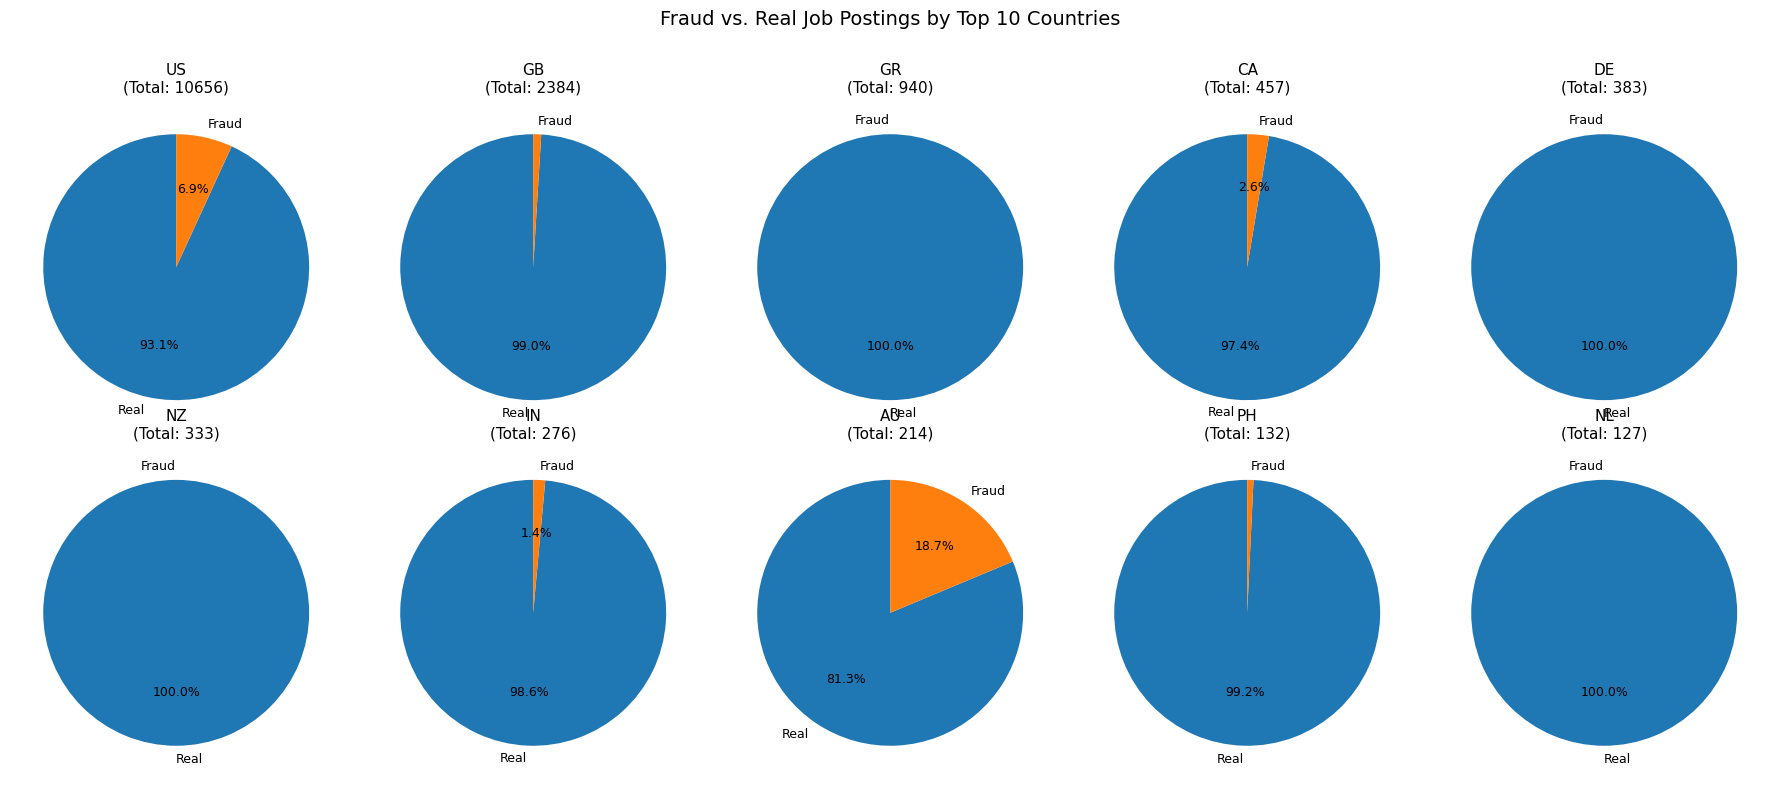

In [ ]:
import matplotlib.pyplot as plt

# Extract country
df['country'] = df['location'].str.split(',').str[0]

# Top 10 countries by total count
top_countries = df['country'].value_counts().head(10).index
df_top = df[df['country'].isin(top_countries)]

# Set up grid: 2 rows x 5 columns
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()

for idx, country in enumerate(top_countries):
    # Get counts for real (0) and fraud (1) in this country
    counts = df_top[df_top['country'] == country]['fraudulent'].value_counts().sort_index()
    # Ensure both classes are present
    real = counts.get(0, 0)
    fraud = counts.get(1, 0)
    sizes = [real, fraud]
    labels = ['Real', 'Fraud']
    colors = ['#1f77b4', '#ff7f0e']

    wedges, texts, autotexts = axes[idx].pie(
        sizes,
        labels=labels,
        colors=colors,
        autopct=lambda pct: f'{pct:.1f}%' if pct > 1 else '',  # skip tiny labels
        startangle=90,
        textprops={'fontsize': 9}
    )
    axes[idx].set_title(f'{country}\n(Total: {real + fraud})', fontsize=11)

# Hide any unused subplots (shouldn't be needed for top 10)
for j in range(len(top_countries), len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Fraud vs. Real Job Postings by Top 10 Countries', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
#numeric columns have no missing data

# Fill missing text with empty string
text_cols_clean = ['title', 'location', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits']
for col in text_cols_clean:
    if col in df.columns:
        df[col] = df[col].fillna('')

# Fill missing data of categorical data
df['department'] = df['department'].fillna('Other')
df['employment_type'] = df['employment_type'].fillna('Other') # "Other" column is given
df['required_experience'] = df['required_experience'].fillna('Not Applicable') # "Not Applicable" is already a category
df['required_education'] = df['required_education'].fillna('Unspecified') # "Unspecified" is already a category
df['industry'] = df['industry'].fillna('Not Applicable') # Create new category of Not Applicable
df['function'] = df['function'].fillna('Other') # "Other" column is already a category
df['country'] = df['country'].fillna('Unspecified') # Create new category of unspecified

df = df.drop(columns=['job_id', 'location'])

df.head()

,title,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country
0,Marketing Intern,Marketing,,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,Unspecified,Not Applicable,Marketing,0,US
1,Customer Service - Cloud Video Production,Success,,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,Unspecified,Marketing and Advertising,Customer Service,0,NZ
2,Commissioning Machinery Assistant (CMA),Other,,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,Other,Not Applicable,Unspecified,Not Applicable,Other,0,US
3,Account Executive - Washington DC,Sales,,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,Bill Review Manager,Other,,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US


In [ ]:
print(df.isnull().sum())

title                  0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
country                0
dtype: int64


# **2. Feature Engineering & Data Augmentation**

- **Feature Engineering**: Create new features
- **Text Processing**: TF-IDF or embeddings (if using text fields).
- **Encoding**: One-hot / label encoding for categorical variables.
- **Data Augmentation Strategies**:
  - SMOTE / ADASYN (for minority class)  
  - Random oversampling/undersampling  
  - Synthetic feature generation

> *Evaluate augmentation methods using Logistic Regression as a baseline.*

---

## **2.1. Feature Engineering**

### **2.1.1. Salary Features**

In [ ]:
# Salary Features
# Date Patterns to Remove and Change Empty
date_patterns = [
  r'\b[A-Za-z]{3}-\d{4}\b',      # Oct-2025, Jan-2024
  r'\b\d{1,2}-[A-Za-z]{3}\b',    # 08-Sep, 1-Jan
  r'\b[A-Za-z]{3}-\d{1,2}\b',    # Sep-08, Jan-1
]
for pattern in date_patterns:
  df['salary_range'] = df['salary_range'].str.replace(pattern, '', regex=True)

df['is_empty_salary'] = df['salary_range'].isnull().astype(int)

df['sal_min'] = np.where (
  df['salary_range'].str.contains('-', na=False),                             # Check if 0-100 OR 100
  pd.to_numeric(df['salary_range'].str.split('-').str[0], errors='coerce'),   # If is a Range, take the left [0]
  pd.to_numeric(df['salary_range'], errors='coerce')                          # If is not, just take the number
)
df['sal_max'] = np.where (
  df['salary_range'].str.contains('-', na=False),                             # Check if 0-100 OR 100
  pd.to_numeric(df['salary_range'].str.split('-').str[1], errors='coerce'),   # If is a Range, take the left [100]
  pd.to_numeric(df['salary_range'], errors='coerce')                          # If is not, just take the number
)
df['sal_mid'] = (df['sal_min'] + df['sal_max']) / 2
df['sal_spread'] = df['sal_max'] - df['sal_min']
df['sal_cv'] = df['sal_spread'] / df['sal_mid']
df['sal_cv'] = df['sal_cv'].replace([np.inf, -np.inf], np.nan)
df['sal_cv'] = df['sal_cv'].clip(upper=5)

df = df.drop('salary_range', axis=1)

salary_cols = ['sal_min', 'sal_max', 'sal_mid', 'sal_spread', 'sal_cv']
print("Top 5 rows of new salary columns:")
df[salary_cols].head(10)

Top 5 rows of new salary columns:


,sal_min,sal_max,sal_mid,sal_spread,sal_cv
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN
6,20000.0,28000.0,24000.0,8000.0,0.333333
7,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN


### **2.1.2. Text Features**

In [ ]:
# Is the text empty?
text_cols = ['title', 'description', 'requirements', 'benefits', 'company_profile']
for col in text_cols:
  df[f'is_empty_{col}'] = df[col].str.strip() == ''

# How many missing information in the job posting
missing_values = ['', np.nan, 'Other', 'Not Applicable', 'Unspecified']
cols_with_missing = df.columns[df.apply(lambda col: col.isin(missing_values).any())].tolist() + ['telecommuting', 'has_company_logo', 'has_questions']
cols_with_missing = [c for c in cols_with_missing if c not in ['sal_mid', 'sal_spread', 'sal_cv']]

# Count missing info per row
df['missing_info_count'] = df[cols_with_missing].apply(lambda row: row.map(lambda x: x in missing_values or x == 0).sum(), axis=1)

print("Columns with Missing Data: ", cols_with_missing)
df['missing_info_count'].head(10)

# field lengths
for col in text_cols:
  df[f'{col}_len'] = df[col].str.split().str.len()

def any_match_across_text_columns(pattern: str):
  # start with the first column's boolean matches
  first_col_series = df[text_cols[0]].fillna('').str.lower()
  matches_any_column = first_col_series.str.contains(pattern, regex=True)

  # or matches from the remaining columns
  for column_name in text_cols[1:]:
    column_series = df[column_name].fillna('').str.lower()
    matches_any_column = matches_any_column | column_series.str.contains(pattern, regex=True)

  return matches_any_column.astype('int8')

# off platform contact hooks may be suspicious (scammers might try pushing applicants off platform for less moderation or ease to phish)
# For URL, Email and Phone
contact_pattern = (
  r'(?:(?:https?://|www\.)|'
  r'(?:[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,})|'
  r'(?:\+?\d[\d\s().-]{7,}\d))'
)

df['txt_has_contact'] = any_match_across_text_columns(contact_pattern)

Columns with Missing Data:  ['department', 'company_profile', 'description', 'requirements', 'benefits', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'country', 'sal_min', 'sal_max', 'telecommuting', 'has_company_logo', 'has_questions']


### **2.1.3. Interaction Terms**

In [ ]:
# Pairwise interactions

# List of boolean columns
bool_cols = ["telecommuting", "has_company_logo", "has_questions"]

# Generate pairwise interaction features with proper naming
interaction_cols = []
for i in range(len(bool_cols)):
  for j in range(i + 1, len(bool_cols)):
    col1, col2 = bool_cols[i], bool_cols[j]
    # Proper naming convention: lowercase, double underscores
    col_name = f"{col1}__x__{col2}"
    df[col_name] = (df[col1] * df[col2]).astype("int8")
    interaction_cols.append(col_name)

# Display summary
print("Base boolean columns:", bool_cols)
print("Interaction columns:", interaction_cols)
df[interaction_cols].head(5)

Base boolean columns: ['telecommuting', 'has_company_logo', 'has_questions']
Interaction columns: ['telecommuting__x__has_company_logo', 'telecommuting__x__has_questions', 'has_company_logo__x__has_questions']


,telecommuting__x__has_company_logo,telecommuting__x__has_questions,has_company_logo__x__has_questions
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,1


### **2.1.4. TF-IDF Embeddings**

In [ ]:
# Check the stopwords
print(set(stopwords.words('english')))

{'ours', 'of', "i'm", 'so', 'doesn', "aren't", 'myself', 'into', "we're", 'how', 'down', 'did', 'why', "doesn't", "she'd", "you're", "couldn't", 'now', 'wasn', 'once', "hadn't", 'be', 'too', 'don', 'during', 'any', "haven't", 'between', "hasn't", "won't", 'this', "isn't", 'just', 'your', 'but', 'i', 'was', 'our', 'haven', 'all', 'a', 'will', 'if', 'both', 'do', 'isn', "should've", 'being', "shouldn't", 'with', 've', 'against', 'some', 'again', 'what', 'few', 'from', 'no', 'it', 'own', 'other', 'over', "you'd", 'does', "don't", "needn't", 'mustn', 'only', 'to', 'who', 'ma', 'through', 'then', 'when', "we'd", 'whom', 'nor', "mightn't", 'about', 'having', 'further', "they'll", 'them', 'their', 'yourself', 'me', "i'd", "they're", 'these', 'had', 'is', "i'll", "she's", "that'll", 'itself', 'after', 'here', 'as', "you've", 'hasn', 'has', 'while', 'by', 'she', 's', "wasn't", 'have', 'ourselves', 'couldn', 'should', 'such', 're', 'where', 'll', 'wouldn', 'theirs', 't', 'weren', 'and', 'you', '

In [ ]:
# Merge all the text into 1 column
df['merged_text'] = df[['title', 'company_profile', 'description', 'requirements', 'benefits']].agg(' '.join, axis=1)

# Clean the text by r
def clean_text(text):
  text = re.sub(r'[^a-zA-Z\s]', '', text).lower()

  # Remove stopwords
  stop = set(stopwords.words('english')) - {"not", "no"} # Keep not and no as there can be potential usefulness
  text = ' '.join([word for word in text.split() if word not in stop])

  # Lemmatize
  lemmatizer = WordNetLemmatizer()
  text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

  return text

df['merged_text'] = df['merged_text'].apply(clean_text)
display(df[['merged_text', 'fraudulent']].head())

df = df.drop(['title', 'company_profile', 'description', 'requirements', 'benefits'], axis=1)

,merged_text,fraudulent
0,marketing intern food weve created groundbreak...,0
1,customer service cloud video production second...,0
2,commissioning machinery assistant cma valor se...,0
3,account executive washington dc passion improv...,0
4,bill review manager spotsource solution llc gl...,0


In [ ]:
X = df.drop(columns=['fraudulent'])
y = df['fraudulent']

# Train Test Split to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4012)

print("Training X set shape:", X_train.shape)
print("Training y set shape:", y_train.shape)
print("Testing X set shape:", X_test.shape)
print("Testing y set shape:", y_test.shape)

X_train_text = X_train['merged_text']
X_test_text = X_test['merged_text']

X_train_num = X_train.drop(columns=['merged_text'])
X_test_num = X_test.drop(columns=['merged_text'])

Training X set shape: (14304, 32)
Training y set shape: (14304,)
Testing X set shape: (3576, 32)
Testing y set shape: (3576,)


In [ ]:
# Create TF-IDF Features from the text
tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=5)

X_train_tfidf_embed = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf_embed  = tfidf_vectorizer.transform(X_test_text).toarray()

print("Shape of X_train_embed:", X_train_tfidf_embed.shape)
print("Shape of X_test_embed:", X_test_tfidf_embed.shape)

Shape of X_train_embed: (14304, 5000)
Shape of X_test_embed: (3576, 5000)


In [ ]:
fraud_txts = X_train_text[y_train == 1]
real_txts = X_train_text[y_train == 0]

vectorizer = CountVectorizer(ngram_range = (2,3), min_df = 3)
fraud_vec = vectorizer.fit_transform(fraud_txts)
auth_vec = vectorizer.transform(real_txts)

fraud_freq = np.asarray(fraud_vec.sum(axis=0)).flatten()
auth_freq = np.asarray(auth_vec.sum(axis=0)).flatten()
freq_diff = fraud_freq - auth_freq

feature_names = np.array(vectorizer.get_feature_names_out())
sorted_idx = np.argsort(freq_diff)[::-1]
sorted_phrases = feature_names[sorted_idx]

unique_phrases = []
unique_set = set()
for phrase in sorted_phrases:
    overlaps = [up for up in unique_phrases if phrase in up or up in phrase or up == phrase]

    if not overlaps:
        unique_phrases.append(phrase)
        unique_set.add(phrase)

    else:
        longest = max([phrase] + overlaps, key=lambda x: len(x.split()))

        for ov in overlaps:
            if ov in unique_phrases:
                unique_phrases.remove(ov)
                unique_set.discard(ov)

        if longest not in unique_set:
            unique_phrases.append(longest)
            unique_set.add(longest)

    if len(unique_phrases) >= 15:
        break
print("Top distinctive (deduplicated) phrases in fraudulent postings:")
for p in unique_phrases:
    print(" -", p)

def contains_top_phrases(text):
    return float(any(p in text for p in unique_phrases))


X_train_num['has_fraud_phrases'] = X_train_text.apply(contains_top_phrases)
X_test_num['has_fraud_phrases'] = X_test_text.apply(contains_top_phrases)


Top distinctive (deduplicated) phrases in fraudulent postings:
 - aker solution
 - signing bonus
 - aptitude staffing
 - candidate encouraged
 - oil gas industry
 - refined resource
 - urlfafceadeaecaedbdfefaae information business
 - discovery production maximize
 - go urlfafceadeaecaedbdfefaae
 - gas industry engineering
 - bring discovery production
 - solution global provider
 - recovery petroleum field
 - design technology bring
 - employ approximately people


## **2.2. Data Encoding**

### **2.2.1. One Hot Encoding**

In [ ]:
TOPK = 20
ohe_cols = ["country", "department", "employment_type", "industry", "function"]

topk_dict = {}

# Map train set
for col in ohe_cols:
    topk = X_train_num[col].value_counts().head(TOPK).index.tolist()
    topk_dict[col] = topk
    X_train_num[col] = X_train_num[col].apply(lambda x: x if x in topk else "Other")

# Map test set using same top-K as train
for col in ohe_cols:
    topk = topk_dict[col]
    X_test_num[col] = X_test_num[col].apply(lambda x: x if x in topk else "Other")

# Initialize OneHotEncoder
ohe_encoder = ce.OneHotEncoder(
    cols=ohe_cols,
    use_cat_names=True,
    handle_unknown='ignore'
)

# Fit on train, transform train and test
X_train_num = ohe_encoder.fit_transform(X_train_num)
X_test_num = ohe_encoder.transform(X_test_num)

# Check for NaNs
print("Train NaNs:", X_train_num.isnull().sum())
print("Test NaNs:", X_test_num.isnull().sum())

print("cols:", list(X_train_num.columns))

Train NaNs: department_Other                      0
department_Engineering                0
department_tech                       0
department_Information Technology     0
department_Marketing                  0
                                     ..
txt_has_contact                       0
telecommuting__x__has_company_logo    0
telecommuting__x__has_questions       0
has_company_logo__x__has_questions    0
has_fraud_phrases                     0
Length: 114, dtype: int64
Test NaNs: department_Other                      0
department_Engineering                0
department_tech                       0
department_Information Technology     0
department_Marketing                  0
                                     ..
txt_has_contact                       0
telecommuting__x__has_company_logo    0
telecommuting__x__has_questions       0
has_company_logo__x__has_questions    0
has_fraud_phrases                     0
Length: 114, dtype: int64
cols: ['department_Other', 'department_Engine

### **2.2.2. Ordinal Encoding**

In [ ]:
# For the mapping
print(df['required_education'].value_counts())
print(df['required_experience'].value_counts())

required_education
Unspecified                          9502
Bachelor's Degree                    5145
High School or equivalent            2080
Master's Degree                       416
Associate Degree                      274
Certification                         170
Some College Coursework Completed     102
Professional                           74
Vocational                             49
Some High School Coursework            27
Doctorate                              26
Vocational - HS Diploma                 9
Vocational - Degree                     6
Name: count, dtype: int64
required_experience
Not Applicable      8166
Mid-Senior level    3809
Entry level         2697
Associate           2297
Director             389
Internship           381
Executive            141
Name: count, dtype: int64


In [ ]:
# Ordinals Encoding

EDU_MAP = {
  "Some High School Coursework": 1,
  "High School or equivalent": 2,
  "Some College Coursework Completed": 3,
  "Associate Degree": 3,
  "Vocational": 4,
  "Vocational - Degree": 4,
  "Vocational - HS Diploma": 4,
  "Certification": 4,
  "Professional": 4,
  "Bachelor's Degree": 5,
  "Master's Degree": 6,
  "Doctorate": 7,
  "Unspecified": 0
}

EXP_MAP = {
  "Not Applicable": 0,
  "Internship": 1,
  "Entry level": 2,
  "Associate": 3,
  "Mid-Senior level": 4,
  "Director": 5,
  "Executive": 6
}

X_train_num["required_education"] = X_train_num["required_education"].astype(str).str.strip().map(EDU_MAP).astype("int8")
X_train_num["required_experience"] = X_train_num["required_experience"].astype(str).str.strip().map(EXP_MAP).astype("int8")

X_test_num["required_education"] = X_test_num["required_education"].astype(str).str.strip().map(EDU_MAP).astype("int8")
X_test_num["required_experience"] = X_test_num["required_experience"].astype(str).str.strip().map(EXP_MAP).astype("int8")

cols = ["required_education","required_experience"]
print(X_train_num[cols].head(8).to_string(index=False))

 required_education  required_experience
                  5                    3
                  2                    3
                  0                    0
                  0                    0
                  3                    3
                  5                    4
                  5                    4
                  0                    0


In [ ]:
print(X_train_num.isnull().sum()[X_train_num.isnull().sum() > 0])

sal_min       12004
sal_max       12004
sal_mid       12004
sal_spread    12004
sal_cv        12111
dtype: int64


In [ ]:
# Done after train_test_split to get rid of NaN --> Impute median to the salary engineered features to not affect the distribution and have a flag to see that it was supposed to be empty.
cols_with_nan = X_train_num.columns[X_train_num.isnull().any()]

imp = SimpleImputer(strategy='median')
X_train_num[cols_with_nan] = imp.fit_transform(X_train_num[cols_with_nan])
X_test_num[cols_with_nan] = imp.transform(X_test_num[cols_with_nan])

print(X_train_num.isnull().sum()[X_train_num.isnull().sum() > 0])

Series([], dtype: int64)


### **2.2.3. Scaling**

In [ ]:
# List of columns to scale
scaled_cols = ['sal_min', 'sal_max', 'sal_mid', 'sal_spread',
               'sal_cv', 'title_len', 'description_len',
               'requirements_len', 'benefits_len', 'company_profile_len', 'required_education', 'required_experience']

scaler = StandardScaler()

# Fit on train and transform both train and test
X_train_num[scaled_cols] = scaler.fit_transform(X_train_num[scaled_cols])
X_test_num[scaled_cols] = scaler.transform(X_test_num[scaled_cols])

# Check result
print(X_train_num[scaled_cols].head())

        sal_min   sal_max   sal_mid  sal_spread    sal_cv  title_len  \
7748  -0.012030 -0.012460 -0.012251   -0.013421 -0.091423  -1.332038   
10443 -0.014122 -0.014367 -0.014483   -0.013780  0.492309  -0.850756   
17    -0.012030 -0.012460 -0.012251   -0.013421 -0.091423   2.036936   
2951  -0.012030 -0.012460 -0.012251   -0.013421 -0.091423  -0.850756   
9049  -0.011396 -0.010802 -0.011249   -0.008644  1.633240   1.074372   

       description_len  requirements_len  benefits_len  company_profile_len  \
7748         -0.179847         -0.255288     -0.608190             0.249600   
10443        -0.342041         -0.512858     -0.608190            -1.079350   
17           -0.901614         -0.844019     -0.567765             0.447777   
2951          0.014787         -0.954406     -0.608190             0.447777   
9049          1.596188          1.130682      1.210941             2.802585   

       required_education  required_experience  
7748             1.327253             0.733

### **2.2.4. Preparing the X_train and X_test**

In [ ]:
X_train_num = X_train_num.astype('float')
X_test_num = X_test_num.astype('float')

# Convert numeric to sparse
X_train_num_sparse = csr_matrix(X_train_num.values)
X_test_num_sparse = csr_matrix(X_test_num.values)

# Concatenate the text back with the other features
X_train_tfidf = hstack([X_train_tfidf_embed, X_train_num_sparse])
X_test_tfidf = hstack([X_test_tfidf_embed, X_test_num_sparse])

print("X_train_tfidf shape:", X_train_tfidf.shape)
print("y_train shape:", y_train.shape)
print("X_test_tfidf shape:", X_test_tfidf.shape)
print("y_test shape:", y_test.shape)

X_train_tfidf shape: (14304, 5114)
y_train shape: (14304,)
X_test_tfidf shape: (3576, 5114)
y_test shape: (3576,)


## **2.3. Data Augmentation**

### **2.3.1. Oversampling**

In [ ]:
# Apply Random Over Sampling on training set only
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=4012)
X_train_ros, y_train_ros = ros.fit_resample(X_train_tfidf, y_train)

print(X_train_ros.shape)

(27214, 5114)


In [ ]:
# Apply SMOTE on training set only
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=4012)
X_train_sm, y_train_sm = smote.fit_resample(X_train_tfidf, y_train)

print(X_train_sm.shape)

(27214, 5114)


In [ ]:
# Apply ADASYN on training set only
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(random_state=4012)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_tfidf, y_train)

print(X_train_adasyn.shape)

(27253, 5114)


### **2.3.2. Undersampling**

In [ ]:
# Apply Random Under Sampling on training set only
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=4012)
X_train_rus, y_train_rus = rus.fit_resample(X_train_tfidf, y_train)

print(X_train_rus.shape)

(1394, 5114)


In [ ]:
# Apply Tomek Links on training set only
from imblearn.under_sampling import TomekLinks
tomek = TomekLinks(sampling_strategy='auto', n_jobs=-1)
X_train_tomek, y_train_tomek = tomek.fit_resample(X_train_tfidf, y_train)

print(X_train_tomek.shape)

(14278, 5114)


In [ ]:
# Apply Edited Nearest Neighbours on training set only
from imblearn.under_sampling import EditedNearestNeighbours
enn = EditedNearestNeighbours()
X_train_enn, y_train_enn = enn.fit_resample(X_train_tfidf, y_train)

print(X_train_enn.shape)

(13806, 5114)


### **2.3.3. Hybrid Sampling**

In [ ]:
# Apply SMOTE + Tomek on training set only
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state = 4012)
X_train_smote_tk, y_train_smote_tk = smote_tomek.fit_resample(X_train_tfidf, y_train)

print(X_train_smote_tk.shape)

(27214, 5114)


In [ ]:
# Apply SMOTE + ENN on training set only
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state = 4012)
X_train_smote_enn, y_train_smote_enn = smote_enn.fit_resample(X_train_tfidf, y_train)

print(X_train_smote_enn.shape)

(25944, 5114)


# **3. Logistic Regression**

- Train on **original** and **augmented** datasets.
- Compare performance (Recall, F1-score, AUC-ROC) to select the best augmentation strategy.
- Use this chosen dataset for all subsequent supervised models.

---

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

augmentation_strategies = {
    "Original" : (X_train_tfidf, y_train),
    "ROS": (X_train_ros, y_train_ros),
    "SMOTE": (X_train_sm, y_train_sm),
    "ADASYN": (X_train_adasyn, y_train_adasyn),
    "RUS" : (X_train_rus, y_train_rus),
    "TOMEK" : (X_train_tomek, y_train_tomek),
    "ENN" : (X_train_enn, y_train_enn),
    "SMOTE_TK" : (X_train_smote_tk, y_train_smote_tk),
    "SMOTE_ENN": (X_train_smote_enn, y_train_smote_enn)
}

pipe = Pipeline([
    ('logreg', LogisticRegression(max_iter=1000, random_state=4012))
])

param_grid = [
    {
        'logreg__penalty': ['l2'],
        'logreg__solver': ['lbfgs'],
        'logreg__C': [0.01, 0.1, 1, 10],
        'logreg__class_weight': [None, 'balanced']
    },
    {
        'logreg__penalty': ['l1', 'l2'],
        'logreg__solver': ['liblinear'],
        'logreg__C': [0.01, 0.1, 1, 10],
        'logreg__class_weight': [None, 'balanced']
    }
]


scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': 'roc_auc'
}

results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=4012)


for name, (X_train_cv, y_train_cv) in augmentation_strategies.items():
    print(f"\n Running K-Fold CV with Hyperparameter Tuning on: {name}")

    # Grid-search with cross validation on training set
    grid_search = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring='f1',
        cv=cv,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train_cv, y_train_cv)
    best_model = grid_search.best_estimator_

    print(f'Best params for {name}: {grid_search.best_params_}')

    # evaluate best model using cross-validation
    cv_results = cross_validate(
        best_model,
        X_train_cv,
        y_train_cv,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False,
        error_score='raise'
    )
    metrics_mean = {metric: np.mean(cv_results[f'test_{metric}']) for metric in scoring.keys()}
    metrics_mean["Dataset"] = name
    results.append(metrics_mean)

results_df = pd.DataFrame(results).set_index("Dataset")
print("\n Cross-Validation Results (Mean across folds):")
print(results_df.round(4))


 Running K-Fold CV with Hyperparameter Tuning on: Original
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params for Original: {'logreg__C': 10, 'logreg__class_weight': None, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}

 Running K-Fold CV with Hyperparameter Tuning on: ROS
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params for ROS: {'logreg__C': 10, 'logreg__class_weight': None, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}

 Running K-Fold CV with Hyperparameter Tuning on: SMOTE
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params for SMOTE: {'logreg__C': 10, 'logreg__class_weight': 'balanced', 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}

 Running K-Fold CV with Hyperparameter Tuning on: ADASYN
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params for ADASYN: {'logreg__C': 10, 'logreg__class_weight': None, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}

 Running K-Fold C

# **4. Decision Tree**

- Train a Decision Tree classifier.
- Tune hyperparameters (e.g., `max_depth`, `min_samples_split`).
- Analyze feature importance.

---

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
import numpy as np
import pandas as pd

def evaluate_model(model, X_test, y_test, model_name="Model"):
    """Comprehensive model evaluation"""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }

    print(f"\n {model_name} Evaluation on Test Set:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    print("\n Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n Confusion Matrix:\n{cm}")

    return metrics, y_pred, y_proba

def analyze_combined_feature_importance(model, tfidf_vectorizer, X_train_num_columns, top_n=20):
    """Feature importance analysis for combined TF-IDF + numerical features"""
    dt = model.named_steps['dt']
    importances = dt.feature_importances_
    top_indices = np.argsort(importances)[::-1][:top_n]

    # Get TF-IDF feature count
    tfidf_feature_count = len(tfidf_vectorizer.get_feature_names_out())
    numerical_feature_count = len(X_train_num_columns)
    total_features = len(importances)

    print(f"Feature Structure:")
    print(f"   - TF-IDF features: {tfidf_feature_count}")
    print(f"   - Numerical features: {numerical_feature_count}")
    print(f"   - Total features: {total_features}")

    print(f"\n Top {top_n} Most Important Features:")
    print("=" * 70)

    # Track counts
    tfidf_features_in_top = 0
    numerical_features_in_top = 0

    for i, idx in enumerate(top_indices, 1):
        if idx < tfidf_feature_count:
            # This is a TF-IDF feature (word)
            word = tfidf_vectorizer.get_feature_names_out()[idx]
            print(f"{i:2d}. [WORD]     {word:<25} Importance: {importances[idx]:.4f}")
            tfidf_features_in_top += 1
        else:
            # This is a numerical feature
            numerical_idx = idx - tfidf_feature_count
            if numerical_idx < len(X_train_num_columns):
                feature_name = X_train_num_columns[numerical_idx]
                print(f"{i:2d}. [NUMERICAL] {feature_name:<25} Importance: {importances[idx]:.4f}")
            else:
                print(f"{i:2d}. [NUMERICAL] feature_{numerical_idx:<20} Importance: {importances[idx]:.4f}")
            numerical_features_in_top += 1

    # Summary
    print(f"\n Top {top_n} Feature Composition:")
    print(f"   - TF-IDF words: {tfidf_features_in_top}")
    print(f"   - Numerical features: {numerical_features_in_top}")

    # Create detailed dataframe
    feature_data = []
    for idx in top_indices:
        if idx < tfidf_feature_count:
            feature_type = "TF-IDF"
            feature_name = tfidf_vectorizer.get_feature_names_out()[idx]
        else:
            feature_type = "NUMERICAL"
            numerical_idx = idx - tfidf_feature_count
            if numerical_idx < len(X_train_num_columns):
                feature_name = X_train_num_columns[numerical_idx]
            else:
                feature_name = f"numerical_feature_{numerical_idx}"

        feature_data.append({
            'index': idx,
            'feature_type': feature_type,
            'feature_name': feature_name,
            'importance': importances[idx]
        })

    feature_imp_df = pd.DataFrame(feature_data)
    return feature_imp_df

# ---- Pipeline ----
pipe_dt = Pipeline([
    ('dt', DecisionTreeClassifier(random_state=4012))
])

# ---- Hyperparameter Grid ----
param_grid_dt = {
    'dt__max_depth': [3, 5, 7, 10, None],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4],
    'dt__criterion': ['gini', 'entropy']
}

# ---- 5-fold CV ----
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=4012)

grid_search_dt = GridSearchCV(
    estimator=pipe_dt,
    param_grid=param_grid_dt,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

print(" Training Decision Tree with GridSearchCV...")
grid_search_dt.fit(X_train_smote_enn, y_train_smote_enn)

print("\n Best Decision Tree Params:")
print(grid_search_dt.best_params_)
print(f"Best CV F1-score: {grid_search_dt.best_score_:.4f}")



 Training Decision Tree with GridSearchCV...
Fitting 5 folds for each of 90 candidates, totalling 450 fits

 Best Decision Tree Params:
{'dt__criterion': 'entropy', 'dt__max_depth': None, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2}
Best CV F1-score: 0.9892


In [ ]:
# ---- Use Best Model ----
best_dt_model = grid_search_dt.best_estimator_

# ---- Evaluate on Test Data ----
metrics, y_pred, y_proba = evaluate_model(best_dt_model, X_test_tfidf, y_test, "Decision Tree")

# -----------------------------------------------------------
#              Combined Feature Importance Analysis
# -----------------------------------------------------------

# Get the numerical feature column names (from your original X_train_num)
# If you don't have them, we can use generic names
try:
    numerical_columns = X_train_num.columns.tolist()
except:
    numerical_columns = [f"numerical_feature_{i}" for i in range(X_train_num.shape[1])]

# Analyze features (both TF-IDF and numerical)
feature_imp_df = analyze_combined_feature_importance(best_dt_model, tfidf_vectorizer, numerical_columns)

# ---- Show breakdown by feature type ----
print(f"\n Top TF-IDF Words:")
print("=" * 40)
word_features = feature_imp_df[feature_imp_df['feature_type'] == 'TF-IDF']
for i, row in word_features.iterrows():
    print(f"{i+1:2d}. {row['feature_name']:<20} ({row['importance']:.4f})")

print(f"\n Top Numerical Features:")
print("=" * 40)
numerical_features = feature_imp_df[feature_imp_df['feature_type'] == 'NUMERICAL']
for i, row in numerical_features.iterrows():
    print(f"{i+1:2d}. {row['feature_name']:<20} ({row['importance']:.4f})")

# ---- Model Structure Insights ----
print("\n Model Structure Analysis:")
dt_model = best_dt_model.named_steps['dt']
print(f"Tree depth: {dt_model.get_depth()}")
print(f"Number of leaves: {dt_model.get_n_leaves()}")
print(f"Number of features used: {(dt_model.feature_importances_ > 0).sum()}")

# ---- Cross-validation scores ----
print("\n Cross-validation scores for best model:")
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best_dt_model, X_train_smote_enn, y_train_smote_enn,
                           cv=cv, scoring='f1', n_jobs=-1)
print(f"CV F1 scores: {[f'{score:.4f}' for score in cv_scores]}")
print(f"Mean CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


 Decision Tree Evaluation on Test Set:
Accuracy: 0.9603
Precision: 0.5538
Recall: 0.8225
F1-score: 0.6619
ROC-AUC: 0.8948

 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3407
           1       0.55      0.82      0.66       169

    accuracy                           0.96      3576
   macro avg       0.77      0.89      0.82      3576
weighted avg       0.97      0.96      0.96      3576


 Confusion Matrix:
[[3295  112]
 [  30  139]]
Feature Structure:
   - TF-IDF features: 5000
   - Numerical features: 114
   - Total features: 5114

 Top 20 Most Important Features:
 1. [NUMERICAL] is_empty_company_profile  Importance: 0.2699
 2. [NUMERICAL] has_fraud_phrases         Importance: 0.1806
 3. [WORD]     facilitating              Importance: 0.0765
 4. [NUMERICAL] required_experience       Importance: 0.0416
 5. [WORD]     internet                  Importance: 0.0366
 6. [WORD]     accion                   

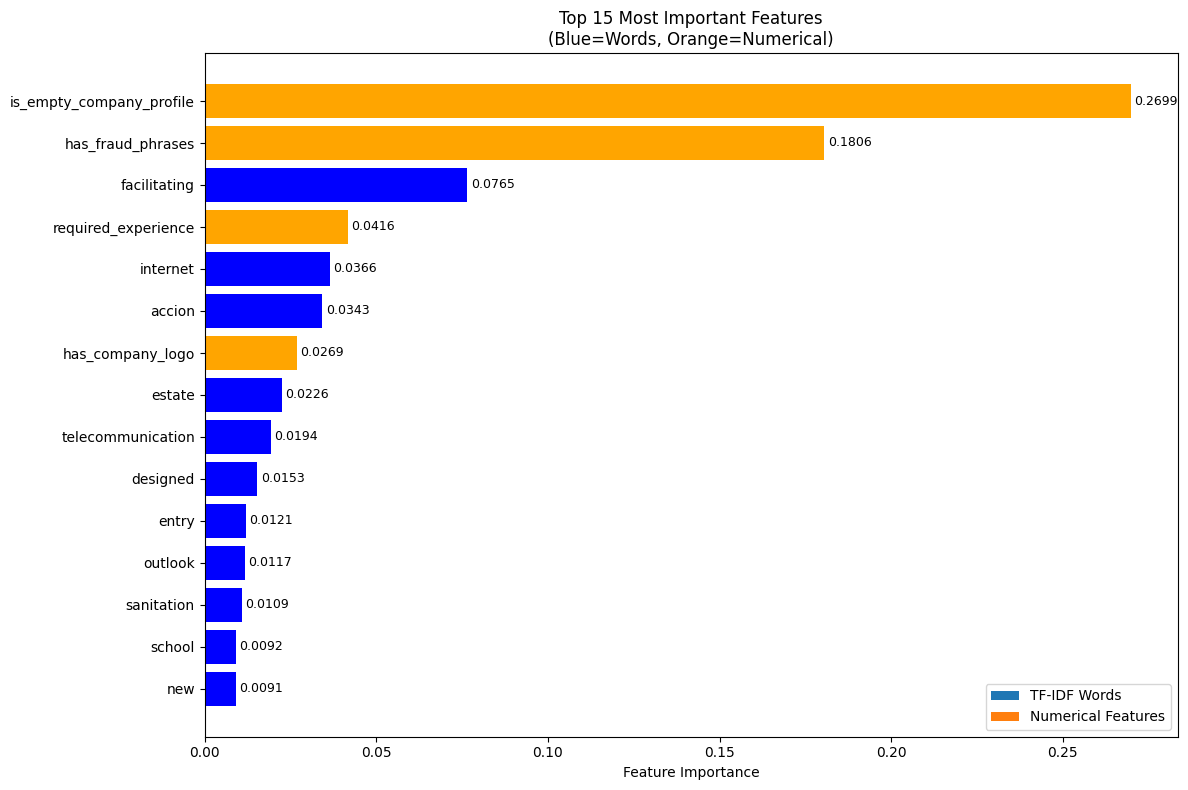

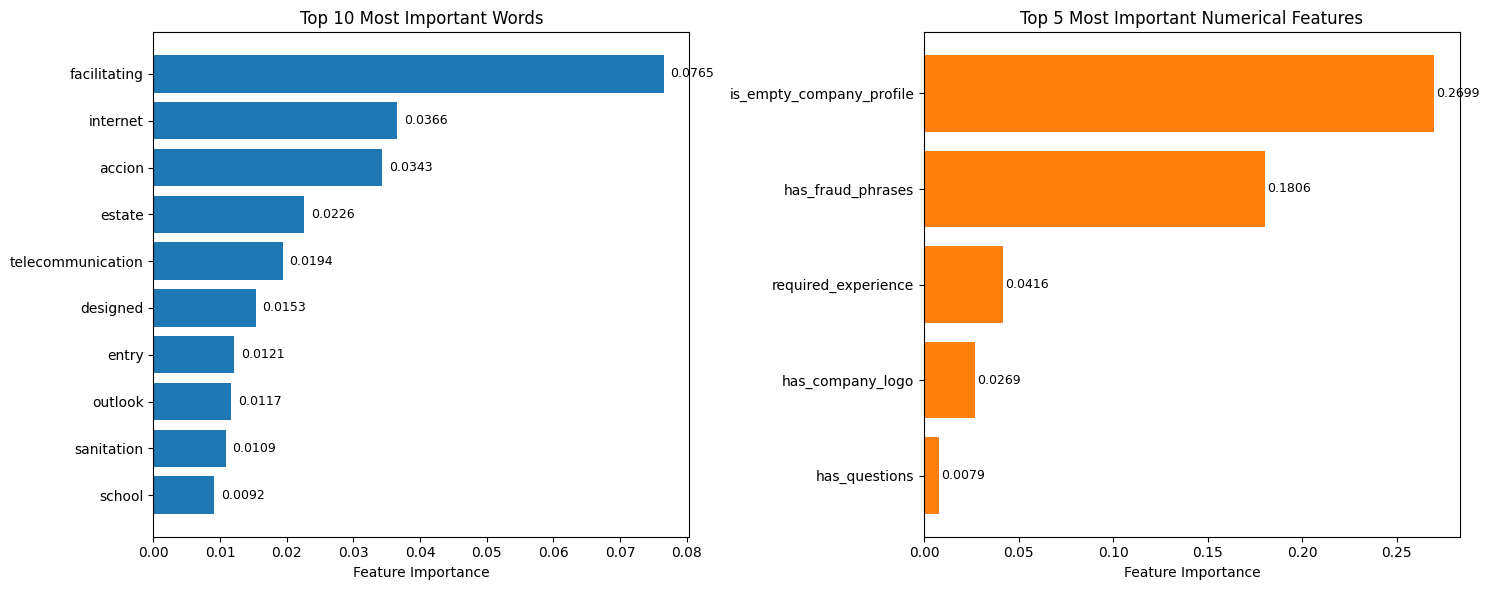

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_feature_importance(feature_imp_df, top_n=15):
    """Plot feature importance for combined TF-IDF and numerical features"""
    plt.figure(figsize=(12, 8))
    top_features = feature_imp_df.head(top_n)

    colors = []
    for feature_type in top_features['feature_type']:
        if feature_type == 'TF-IDF':
            colors.append('blue')
        else:
            colors.append('orange')

    bars = plt.barh(range(len(top_features)), top_features['importance'], color=colors)
    plt.yticks(range(len(top_features)), top_features['feature_name'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Most Important Features\n(Blue=Words, Orange=Numerical)')
    plt.gca().invert_yaxis()

    for i, (importance, feature_type) in enumerate(zip(top_features['importance'], top_features['feature_type'])):
        plt.text(importance + 0.001, i, f'{importance:.4f}', va='center', fontsize=9)

    legend_elements = [
        Patch(facecolor='#1f77b4', label='TF-IDF Words'),
        Patch(facecolor='#ff7f0e', label='Numerical Features')
    ]
    plt.legend(handles=legend_elements, loc='lower right')

    plt.tight_layout()
    plt.show()

# Plot top features
plot_feature_importance(feature_imp_df)

# Additional: Separate plots for each feature type
def plot_feature_importance_by_type(feature_imp_df, top_n=10):
    """Create separate plots for TF-IDF and numerical features"""

    # Filter by feature type
    tfidf_features = feature_imp_df[feature_imp_df['feature_type'] == 'TF-IDF'].head(top_n)
    numerical_features = feature_imp_df[feature_imp_df['feature_type'] == 'NUMERICAL'].head(top_n)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot TF-IDF features
    if len(tfidf_features) > 0:
        ax1.barh(range(len(tfidf_features)), tfidf_features['importance'], color='#1f77b4')
        ax1.set_yticks(range(len(tfidf_features)))
        ax1.set_yticklabels(tfidf_features['feature_name'])
        ax1.set_xlabel('Feature Importance')
        ax1.set_title(f'Top {len(tfidf_features)} Most Important Words')
        ax1.invert_yaxis()

        for i, importance in enumerate(tfidf_features['importance']):
            ax1.text(importance + 0.001, i, f'{importance:.4f}', va='center', fontsize=9)

    # Plot numerical features
    if len(numerical_features) > 0:
        ax2.barh(range(len(numerical_features)), numerical_features['importance'], color='#ff7f0e')
        ax2.set_yticks(range(len(numerical_features)))
        ax2.set_yticklabels(numerical_features['feature_name'])
        ax2.set_xlabel('Feature Importance')
        ax2.set_title(f'Top {len(numerical_features)} Most Important Numerical Features')
        ax2.invert_yaxis()

        for i, importance in enumerate(numerical_features['importance']):
            ax2.text(importance + 0.001, i, f'{importance:.4f}', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

plot_feature_importance_by_type(feature_imp_df)



In [ ]:
# Additional: Summary statistics
def print_feature_importance_summary(feature_imp_df, top_n=20):
    """Print summary statistics about feature importance"""
    total_importance = feature_imp_df['importance'].sum()
    top_n_importance = feature_imp_df.head(top_n)['importance'].sum()

    print(f"\n Feature Importance Summary:")
    print(f"Total importance (all features): {total_importance:.4f}")
    print(f"Top {top_n} features account for: {top_n_importance:.4f} ({top_n_importance/total_importance*100:.1f}%)")

    # Breakdown by type
    tfidf_importance = feature_imp_df[feature_imp_df['feature_type'] == 'TF-IDF']['importance'].sum()
    numerical_importance = feature_imp_df[feature_imp_df['feature_type'] == 'NUMERICAL']['importance'].sum()

    print(f"TF-IDF words total importance: {tfidf_importance:.4f} ({tfidf_importance/total_importance*100:.1f}%)")
    print(f"Numerical features total importance: {numerical_importance:.4f} ({numerical_importance/total_importance*100:.1f}%)")

    # Top features by type
    top_tfidf = feature_imp_df[feature_imp_df['feature_type'] == 'TF-IDF'].head(10)
    top_numerical = feature_imp_df[feature_imp_df['feature_type'] == 'NUMERICAL'].head(10)

    print(f"\n Top 10 Words:")
    for i, row in top_tfidf.iterrows():
        print(f"   {row['feature_name']}: {row['importance']:.4f}")

    print(f"\n Top 10 Numerical Features:")
    for i, row in top_numerical.iterrows():
        print(f"   {row['feature_name']}: {row['importance']:.4f}")

# Print summary
print_feature_importance_summary(feature_imp_df)


 Feature Importance Summary:
Total importance (all features): 0.8156
Top 20 features account for: 0.8156 (100.0%)
TF-IDF words total importance: 0.2886 (35.4%)
Numerical features total importance: 0.5270 (64.6%)

 Top 10 Words:
   facilitating: 0.0765
   internet: 0.0366
   accion: 0.0343
   estate: 0.0226
   telecommunication: 0.0194
   designed: 0.0153
   entry: 0.0121
   outlook: 0.0117
   sanitation: 0.0109
   school: 0.0092

 Top 10 Numerical Features:
   is_empty_company_profile: 0.2699
   has_fraud_phrases: 0.1806
   required_experience: 0.0416
   has_company_logo: 0.0269
   has_questions: 0.0079


# **5. XGBoost**

- Train an XGBoost classifier.
- Optimize using cross-validation or Bayesian optimization.
- Leverage built-in handling of imbalanced data (`scale_pos_weight`).

---

In [ ]:
!pip install optuna xgboost scikit-learn imbalanced-learn
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
import optuna
from optuna.samplers import TPESampler
import numpy as np

In [ ]:
# Compute scale_pos_weight (ratio of negative to positive samples)
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Objective function for Optuna
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'booster': 'gbtree',
        'scale_pos_weight': pos_weight,
        'random_state': 4012,
        'tree_method': 'hist',  # Faster training
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
    }

    cv_scores = []
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=4012)

    for train_idx, val_idx in skf.split(X_train_tfidf, y_train):
        X_cv_train, X_cv_val = X_train_tfidf[train_idx], X_train_tfidf[val_idx]
        y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = xgb.XGBClassifier(**params, early_stopping_rounds=20, use_label_encoder=False)
        model.fit(
            X_cv_train,
            y_cv_train,
            eval_set=[(X_cv_val, y_cv_val)],
            verbose=False
        )

        preds = model.predict_proba(X_cv_val)[:, 1]
        auc = roc_auc_score(y_cv_val, preds)
        cv_scores.append(auc)

    return np.mean(cv_scores)

In [ ]:
'''
import logging
import optuna
from optuna.samplers import TPESampler

# Enable Optuna logging
optuna.logging.set_verbosity(optuna.logging.INFO)  # or DEBUG for even more detail

# Optional: Configure Python's root logger to show Optuna logs in Colab/Jupyter
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(message)s",
    level=logging.INFO,
    force=True  # Ensures config is applied even if root logger was already set
)

def print_trial_callback(study: optuna.Study, trial: optuna.trial.FrozenTrial):
    print(f"\n--- Trial {trial.number} ---")
    print(f"Params: {trial.params}")
    print(f"Value (AUC): {trial.value}")
    print("-" * 40)

# Run Bayesian Optimization
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=4012))
study.optimize(objective, n_trials=50, callbacks=[print_trial_callback])  # Tune this number (30–100) based on time

print("Best trial:")
print(study.best_trial.params)
print("Best AUC:", study.best_value)
'''

'\nimport logging\nimport optuna\nfrom optuna.samplers import TPESampler\n\n# Enable Optuna logging\noptuna.logging.set_verbosity(optuna.logging.INFO)  # or DEBUG for even more detail\n\n# Optional: Configure Python\'s root logger to show Optuna logs in Colab/Jupyter\nlogging.basicConfig(\n    format="%(asctime)s - %(levelname)s - %(message)s",\n    level=logging.INFO,\n    force=True  # Ensures config is applied even if root logger was already set\n)\n\ndef print_trial_callback(study: optuna.Study, trial: optuna.trial.FrozenTrial):\n    print(f"\n--- Trial {trial.number} ---")\n    print(f"Params: {trial.params}")\n    print(f"Value (AUC): {trial.value}")\n    print("-" * 40)\n\n# Run Bayesian Optimization\nstudy = optuna.create_study(direction=\'maximize\', sampler=TPESampler(seed=4012))\nstudy.optimize(objective, n_trials=50, callbacks=[print_trial_callback])  # Tune this number (30–100) based on time\n\nprint("Best trial:")\nprint(study.best_trial.params)\nprint("Best AUC:", study.

In [ ]:
# Final model with best params
#pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
best_params = {'max_depth': 5, 'learning_rate': 0.23044011186379484, 'subsample': 0.8996749785105427, 'colsample_bytree': 0.9292154146645059, 'min_child_weight': 2, 'gamma': 0.3085921135067504, 'reg_alpha': 6.950093601777965, 'reg_lambda': 5.961164664370379}
best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'scale_pos_weight': pos_weight,
    'random_state': 4012,
    'use_label_encoder': False,
    'tree_method': 'hist'
})

final_model = xgb.XGBClassifier(**best_params,early_stopping_rounds=100,)

# Fit on full (original) training data
final_model.fit(
    X_train_tfidf,
    y_train,
    eval_set=[(X_test_tfidf, y_test)],
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9292154146645059, device=None,
              early_stopping_rounds=100, enable_categorical=False,
              eval_metric='auc', feature_types=None, feature_weights=None,
              gamma=0.3085921135067504, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.23044011186379484,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
# Predictions
y_pred = final_model.predict(X_test_tfidf)
y_pred_proba = final_model.predict_proba(X_test_tfidf)[:, 1]

# Metrics
print("Test Set Performance:")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
print(f"F1       : {f1_score(y_test, y_pred):.4f}")
print(f"AUC      : {roc_auc_score(y_test, y_pred_proba):.4f}")

Test Set Performance:
Accuracy : 0.9732
Precision: 0.6622
Recall   : 0.8817
F1       : 0.7563
AUC      : 0.9879


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)
import xgboost as xgb

#log predictions
y_pred_proba = final_model.predict_proba(X_test_tfidf)[:, 1]  # Probability of class 1 (fake)
# this is cuz roc_auc_score(y_true, y_score) expects y_score to be confidence scores for the positive class (class 1).
y_pred = final_model.predict(X_test_tfidf)

# Safety
y_pred_proba = np.nan_to_num(y_pred_proba, nan=0.5, posinf=1.0, neginf=0.0)
y_pred_proba = np.clip(y_pred_proba, 0.0, 1.0)

In [ ]:
# Core Metrics
test_acc = accuracy_score(y_test, y_pred)
test_prec = precision_score(y_test, y_pred)
test_rec = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred_proba)
test_ap = average_precision_score(y_test, y_pred_proba)

print("=== XGBoost Final Model Test Performance ===")
print(f"Accuracy : {test_acc:.4f}")
print(f"Precision: {test_prec:.4f}")
print(f"Recall   : {test_rec:.4f}")
print(f"F1-Score : {test_f1:.4f}")
print(f"AUC      : {test_auc:.4f}")
print(f"Avg Prec : {test_ap:.4f}")
print("\n" + "="*50 + "\n")

=== XGBoost Final Model Test Performance ===
Accuracy : 0.9732
Precision: 0.6622
Recall   : 0.8817
F1-Score : 0.7563
AUC      : 0.9879
Avg Prec : 0.9006




In [ ]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Real (0)', 'Fake (1)']))

Detailed Classification Report:
              precision    recall  f1-score   support

    Real (0)       0.99      0.98      0.99      3407
    Fake (1)       0.66      0.88      0.76       169

    accuracy                           0.97      3576
   macro avg       0.83      0.93      0.87      3576
weighted avg       0.98      0.97      0.97      3576



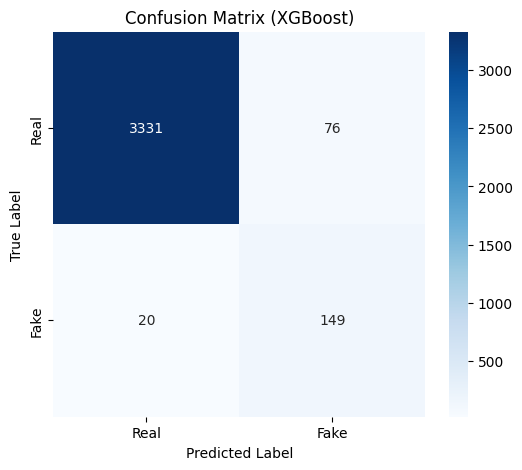

In [ ]:
# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix (XGBoost)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# ROC & Precision-Recall Curves
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

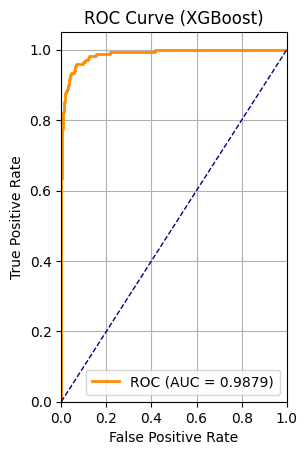

In [ ]:
# ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (XGBoost)')
plt.legend(loc="lower right")
plt.grid(True)

# **6. Neural Network**

- Build a feedforward neural network (MLP).
- Use dropout, batch normalization, and early stopping.
- Optimize for F1-score (due to class imbalance).
---

In [ ]:
# NN requires dense arrays while X_train_tfidf and X_test_tfidf are sparse matrices. Convert to dense
X_train_dense = X_train_tfidf.toarray().astype(np.float32)
X_test_dense = X_test_tfidf.toarray().astype(np.float32)

# Safety: Need to replace any remaining inf with nan, then impute or clip
X_train_dense = np.nan_to_num(X_train_dense, nan=0.0, posinf=0.0, neginf=0.0)
X_test_dense = np.nan_to_num(X_test_dense, nan=0.0, posinf=0.0, neginf=0.0)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score
import numpy as np

# Compute class weights - helpful for imbalance
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class weights:", class_weight_dict)

def create_mlp(input_dim):
    model = Sequential([
        Dense(256, input_dim=input_dim, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        Dropout(0.2),

        Dense(1, activation='sigmoid')  # binary classification
    ])
    return model

# Instantiate
input_dim = X_train_dense.shape[1]
model = create_mlp(input_dim)

# Compile: use binary crossentropy + Adam optimizer
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Early stopping on validation F1
early_stop = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train
history = model.fit(
    X_train_dense, y_train_np,
    validation_data=(X_test_dense, y_test_np),
    epochs=100,
    batch_size=64,
    class_weight=class_weight_dict,  # handle imbalance
    callbacks=[early_stop],
    verbose=1
)

Class weights: {0: np.float64(0.5256118174469023), 1: np.float64(10.261119081779054)}
Epoch 1/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.4954 - auc: 0.7021 - loss: 0.6984 - val_accuracy: 0.9567 - val_auc: 0.9497 - val_loss: 0.1806
Epoch 2/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8889 - auc: 0.9552 - loss: 0.2779 - val_accuracy: 0.9771 - val_auc: 0.9827 - val_loss: 0.0701
Epoch 3/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9150 - auc: 0.9845 - loss: 0.1684 - val_accuracy: 0.9695 - val_auc: 0.9822 - val_loss: 0.0736
Epoch 4/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9464 - auc: 0.9896 - loss: 0.1240 - val_accuracy: 0.9676 - val_auc: 0.9858 - val_loss: 0.0872
Epoch 5/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9522 - auc: 0.9903 - loss: 0.1146 - val_accuracy: 0.9653 - val_auc: 0.9848 - val_loss: 0.0876
Epoch 6/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9629 - auc: 0.9927 - loss: 0.1020 - val_

In [ ]:
y_pred_proba = model.predict(X_test_dense).flatten()

# Safety: replace any NaN/Inf in predictions
y_pred_proba = np.nan_to_num(y_pred_proba, nan=0.5, posinf=1.0, neginf=0.0)

# Clip to [0,1] to be safe
y_pred_proba = np.clip(y_pred_proba, 0.0, 1.0)

y_pred = (y_pred_proba > 0.5).astype(int)

test_f1 = f1_score(y_test_np, y_pred)
test_auc = roc_auc_score(y_test_np, y_pred_proba)

print(f"Test F1-Score: {test_f1:.4f}")
print(f"Test AUC:      {test_auc:.4f}")

112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Test F1-Score: 0.7290
Test AUC:      0.9896


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

# Prediction
y_pred_proba = model.predict(X_test_dense).flatten()

# Safety net: replace invalid values
y_pred_proba = np.nan_to_num(y_pred_proba, nan=0.5, posinf=1.0, neginf=0.0)
y_pred_proba = np.clip(y_pred_proba, 0.0, 1.0)

# Default threshold = 0.5
y_pred = (y_pred_proba > 0.5).astype(int)

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
# Core Metrics
test_acc = accuracy_score(y_test_np, y_pred)
test_prec = precision_score(y_test_np, y_pred)
test_rec = recall_score(y_test_np, y_pred)
test_f1 = f1_score(y_test_np, y_pred)
test_auc = roc_auc_score(y_test_np, y_pred_proba)
test_ap = average_precision_score(y_test_np, y_pred_proba)  # for imbalanced data

print("=== Neural Network Test Performance ===")
print(f"Accuracy : {test_acc:.4f}")
print(f"Precision: {test_prec:.4f}")
print(f"Recall   : {test_rec:.4f}")
print(f"F1-Score : {test_f1:.4f}")
print(f"AUC      : {test_auc:.4f}")
print(f"Avg Prec : {test_ap:.4f}")
print("\n" + "="*50 + "\n")


=== Neural Network Test Performance ===
Accuracy : 0.9676
Precision: 0.6023
Recall   : 0.9231
F1-Score : 0.7290
AUC      : 0.9896
Avg Prec : 0.9059




In [ ]:
# Detailed Classification Report
print("Classification Report:")
print(classification_report(y_test_np, y_pred, target_names=['Real (0)', 'Fake (1)']))


Detailed Classification Report:
              precision    recall  f1-score   support

    Real (0)       1.00      0.97      0.98      3407
    Fake (1)       0.60      0.92      0.73       169

    accuracy                           0.97      3576
   macro avg       0.80      0.95      0.86      3576
weighted avg       0.98      0.97      0.97      3576



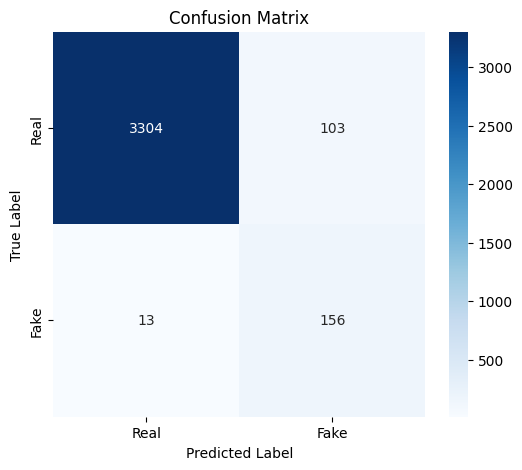

In [ ]:
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test_np, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


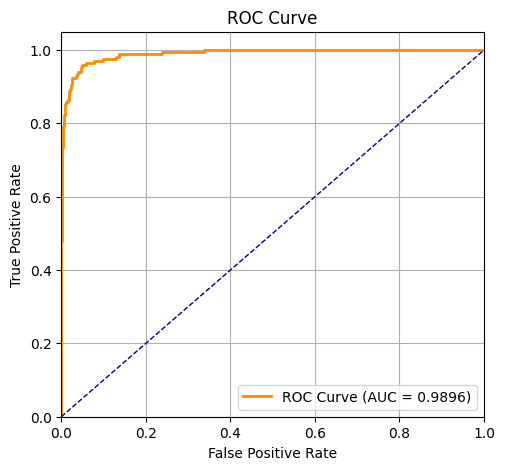

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test_np, y_pred_proba)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)

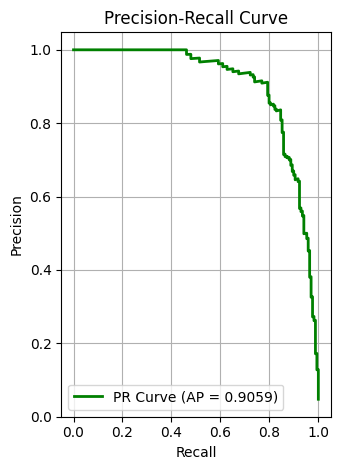

In [ ]:
# Precision-Recall Curve (Better for Imbalanced Data)
precision_vals, recall_vals, _ = precision_recall_curve(y_test_np, y_pred_proba)
plt.subplot(1, 2, 2)
plt.plot(recall_vals, precision_vals, color='green', lw=2, label=f'PR Curve (AP = {test_ap:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Optimize Threshold for F1
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y_test_np, (y_pred_proba >= t).astype(int)) for t in thresholds]
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\n Optimal Threshold for F1: {best_thresh:.2f} → F1 = {best_f1:.4f}")

# Re-predict with best threshold
y_pred_opt = (y_pred_proba >= best_thresh).astype(int)
print(f"\nPerformance at Optimal Threshold ({best_thresh:.2f}):")
print(f"  F1      : {f1_score(y_test_np, y_pred_opt):.4f}")
print(f"  Recall  : {recall_score(y_test_np, y_pred_opt):.4f}")
print(f"  Prec    : {precision_score(y_test_np, y_pred_opt):.4f}")


🔍 Optimal Threshold for F1: 0.89 → F1 = 0.8290

Performance at Optimal Threshold (0.89):
  F1      : 0.8290
  Recall  : 0.8462
  Prec    : 0.8125


# **7. Autoencoder**

- Train a deep autoencoder on **non-fraudulent** samples only.
- Use reconstruction error as anomaly score.
- Evaluate on full test set (including fraudulent samples).

---

In [ ]:
from pyod.models.auto_encoder import AutoEncoder
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# prepare data (dense arrays)
train_features_dense = X_train_tfidf.toarray()
train_labels = np.asarray(y_train)
# test not used here, its for after CV is completed
test_features_dense = X_test_tfidf.toarray()
test_labels = np.asarray(y_test)

print("Original train shape:", train_features_dense.shape)
print("Test shape:", test_features_dense.shape)

# hyperparameter grid
autoencoder_param_grid = {
  "hidden_neurons": [
    [512, 128, 32, 128, 512],
    [256, 64, 16, 64, 256],
    [256, 64, 64, 256],
  ],
  "epochs": [30, 50],
  "contamination": [0.03, 0.05, 0.07],
}

autoencoder_param_grid_list = list(ParameterGrid(autoencoder_param_grid))
print(f"Total configs to test: {len(autoencoder_param_grid_list)}")

# cross validation setup
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=4012)

cv_results_list = []
best_param_config = None
best_mean_recall = -1.0
best_mean_f1 = None
best_mean_roc_auc = None

for param_config in autoencoder_param_grid_list:
  print("\n---------------------------------------")
  print(f"Testing config: {param_config}")
  fold_metrics_list = []

  for fold_index, (train_index, validation_index) in enumerate(
    stratified_kfold.split(train_features_dense, train_labels),
    start=1,
  ):
    X_train_fold = train_features_dense[train_index]
    y_train_fold = train_labels[train_index]
    X_validation_fold = train_features_dense[validation_index]
    y_validation_fold = train_labels[validation_index]

    # train ONLY on non fraud for this fold
    normal_class_mask_fold = (y_train_fold == 0)
    X_train_normal_only_fold = X_train_fold[normal_class_mask_fold]

    # Autoencoder
    autoencoder_model = AutoEncoder(
      contamination=param_config["contamination"],
      lr=1e-3,
      epoch_num=param_config["epochs"],
      batch_size=256,
      hidden_neuron_list=param_config["hidden_neurons"],
      hidden_activation_name="relu",
      batch_norm=True,
      dropout_rate=0.2,
      verbose=0,
      random_state=4012,
    )

    # fit on normal only data
    autoencoder_model.fit(X_train_normal_only_fold)

    # predict on full validation fold (normals + frauds)
    # reconstruction error based anomaly score
    validation_anomaly_scores = autoencoder_model.decision_function(
      X_validation_fold
    )
    validation_predictions = autoencoder_model.predict(
      X_validation_fold
    )

    accuracy = accuracy_score(y_validation_fold, validation_predictions)
    precision = precision_score(y_validation_fold, validation_predictions, zero_division=0)
    recall = recall_score(y_validation_fold, validation_predictions, zero_division=0)
    f1 = f1_score(y_validation_fold, validation_predictions, zero_division=0)
    roc_auc = roc_auc_score(y_validation_fold, validation_anomaly_scores)

    fold_metrics_list.append({
      "fold": fold_index,
      "accuracy": accuracy,
      "precision": precision,
      "recall": recall,
      "f1": f1,
      "roc_auc": roc_auc,
    })

    print(
      f"  Fold {fold_index}: "
      f"Acc={accuracy:.4f}, Prec={precision:.4f}, Rec={recall:.4f}, "
      f"F1={f1:.4f}, ROC AUC={roc_auc:.4f}"
    )

  # average over folds
  mean_accuracy = np.mean([m["accuracy"] for m in fold_metrics_list])
  mean_precision = np.mean([m["precision"] for m in fold_metrics_list])
  mean_recall = np.mean([m["recall"] for m in fold_metrics_list])
  mean_f1 = np.mean([m["f1"] for m in fold_metrics_list])
  mean_roc_auc = np.mean([m["roc_auc"] for m in fold_metrics_list])

  avg_metrics_dict = {
    "config": param_config,
    "mean_accuracy": mean_accuracy,
    "mean_precision": mean_precision,
    "mean_recall": mean_recall,
    "mean_f1": mean_f1,
    "mean_roc_auc": mean_roc_auc,
  }
  cv_results_list.append(avg_metrics_dict)

  print(
    "  -> Mean over folds:",
    f"Acc={mean_accuracy:.4f}, "
    f"Prec={mean_precision:.4f}, "
    f"Rec={mean_recall:.4f}, "
    f"F1={mean_f1:.4f}, "
    f"ROC AUC={mean_roc_auc:.4f}",
  )

  # select best by mean recall, tie break with F1 then ROC AUC
  if best_param_config is None:
    best_param_config = param_config
    best_mean_recall = mean_recall
    best_mean_f1 = mean_f1
    best_mean_roc_auc = mean_roc_auc
  else:
    is_better_recall = mean_recall > best_mean_recall
    is_tied_recall_better_f1 = np.isclose(mean_recall, best_mean_recall) and (mean_f1 > best_mean_f1)
    is_tied_recall_f1_better_roc = (
      np.isclose(mean_recall, best_mean_recall)
      and np.isclose(mean_f1, best_mean_f1)
      and (mean_roc_auc > best_mean_roc_auc)
    )

    if is_better_recall or is_tied_recall_better_f1 or is_tied_recall_f1_better_roc:
      best_param_config = param_config
      best_mean_recall = mean_recall
      best_mean_f1 = mean_f1
      best_mean_roc_auc = mean_roc_auc

# CV summary
cv_results_dataframe = pd.DataFrame(cv_results_list)
print("\nCV summary (one row per config):")
print(cv_results_dataframe)
print("\nBest config by mean recall:")
print(best_param_config)
print(f"Best mean recall: {best_mean_recall:.4f}")

Original train shape: (14304, 5114)
Test shape: (3576, 5114)
Total configs to test: 18

---------------------------------------
Testing config: {'contamination': 0.03, 'epochs': 30, 'hidden_neurons': [512, 128, 32, 128, 512]}
  Fold 1: Acc=0.9216, Prec=0.2718, Rec=0.3605, F1=0.3100, ROC AUC=0.7644
  Fold 2: Acc=0.9136, Prec=0.2289, Rec=0.3276, F1=0.2695, ROC AUC=0.7178
  Fold 3: Acc=0.9042, Prec=0.1866, Rec=0.2888, F1=0.2267, ROC AUC=0.7211
  -> Mean over folds: Acc=0.9131, Prec=0.2291, Rec=0.3256, F1=0.2687, ROC AUC=0.7344

---------------------------------------
Testing config: {'contamination': 0.03, 'epochs': 30, 'hidden_neurons': [256, 64, 16, 64, 256]}
  Fold 1: Acc=0.9211, Prec=0.2656, Rec=0.3476, F1=0.3011, ROC AUC=0.7465
  Fold 2: Acc=0.9146, Prec=0.2291, Rec=0.3190, F1=0.2667, ROC AUC=0.7044
  Fold 3: Acc=0.9060, Prec=0.1842, Rec=0.2716, F1=0.2195, ROC AUC=0.7034
  -> Mean over folds: Acc=0.9139, Prec=0.2263, Rec=0.3127, F1=0.2624, ROC AUC=0.7181

----------------------------

In [ ]:
# train final Autoencoder on ALL non fraud
normal_class_mask_all = (train_labels == 0)
train_features_normal_only = train_features_dense[normal_class_mask_all]
print("\nFinal training set (normal only) shape:", train_features_normal_only.shape)

best_autoencoder_model = AutoEncoder(
  contamination=best_param_config["contamination"],
  lr=1e-3,
  epoch_num=best_param_config["epochs"],
  batch_size=256,
  hidden_neuron_list=best_param_config["hidden_neurons"],
  hidden_activation_name="relu",
  batch_norm=True,
  dropout_rate=0.2,
  verbose=1,
  random_state=4012,
)

best_autoencoder_model.fit(train_features_normal_only)

# final evaluation on FULL original test set
# reconstruction error scores
test_anomaly_scores = best_autoencoder_model.decision_function(
  test_features_dense
)
test_predictions = best_autoencoder_model.predict(
  test_features_dense
)

print("\nFinal Autoencoder Evaluation on Test Set:")
print("Accuracy: ", accuracy_score(test_labels, test_predictions))
print("Precision: ", precision_score(test_labels, test_predictions, zero_division=0))
print("Recall: ",recall_score(test_labels, test_predictions, zero_division=0))
print("F1 Score: ",f1_score(test_labels, test_predictions, zero_division=0))
print("ROC AUC: ", roc_auc_score(test_labels, test_anomaly_scores))
print("\nConfusion Matrix:\n", confusion_matrix(test_labels, test_predictions))
print("\nClassification Report:\n", classification_report(test_labels, test_predictions, digits=4))


Final training set (normal only) shape: (13607, 5114)


Training: 100%|██████████| 50/50 [00:35<00:00,  1.42it/s]



Final Autoencoder Evaluation on Test Set:
Accuracy:  0.8881431767337807
Precision:  0.17464788732394365
Recall:  0.3668639053254438
F1 Score:  0.2366412213740458
ROC AUC:  0.7721728498409992

Confusion Matrix:
 [[3114  293]
 [ 107   62]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9668    0.9140    0.9396      3407
           1     0.1746    0.3669    0.2366       169

    accuracy                         0.8881      3576
   macro avg     0.5707    0.6404    0.5881      3576
weighted avg     0.9293    0.8881    0.9064      3576



# **8. Deep SVDD**

- Minimize hypersphere volume in latent space; high distance = anomaly.

---

In [ ]:
X_normal_tfidf = X_train_tfidf.toarray()[np.array(y_train)== 0]
X_anomaly_tfidf = X_train_tfidf.toarray()[np.array(y_train) == 1]

print(X_normal_tfidf.shape)
print(X_anomaly_tfidf.shape)

# Split normal data into train + validation ---
X_train_norm, X_val_norm = train_test_split(
    X_normal_tfidf, test_size=0.2, random_state=4012
)

# For validation, combine normal validation + some anomalies ---
X_val = np.vstack([X_val_norm, X_anomaly_tfidf])
y_val = np.hstack([np.zeros(len(X_val_norm)), np.ones(len(X_anomaly_tfidf))])

(13607, 5114)
(697, 5114)


In [ ]:
!pip install pyod
from pyod.models.deep_svdd import DeepSVDD
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# --- Define grid for hidden layers ---
hidden_grid = [
    [128, 64, 32],
    [64, 32, 16],
    [100, 50]
]

best_recall = -1
best_config = None
results = []  # store all metric results

for hidden_neurons in hidden_grid:
    print(f"\n Testing hidden_neurons={hidden_neurons}")

    # Initialize model
    model = DeepSVDD(
        n_features=X_train_norm.shape[1],
        hidden_neurons=hidden_neurons,
        epochs=50,
        contamination=0.05,
        random_state=4012
    )

    # Train only on normal data
    model.fit(X_train_norm)

    # Predict on validation
    y_pred = model.predict(X_val)
    y_scores = model.decision_function(X_val)

    # Compute all metrics
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc = roc_auc_score(y_val, y_scores)

    # Store metrics
    results.append({
        'hidden_neurons': hidden_neurons,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'roc_auc': roc
    })

    # Print metrics
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | "
          f"F1: {f1:.4f} | ROC AUC: {roc:.4f}")

    # Track best recall
    if rec > best_recall:
        best_recall = rec
        best_config = hidden_neurons

# Convert results to a DataFrame for easy viewing
import pandas as pd
results_df = pd.DataFrame(results)
print("\n Summary of all grid results:")
print(results_df)

print(f"\n Best hidden_neurons: {best_config} with Recall: {best_recall:.4f}")

# Train final model with best configuration
final_model = DeepSVDD(
    n_features=X_train_norm.shape[1],
    hidden_neurons=best_config,
    epochs=50,
    contamination=0.05,
    verbose=1,
    random_state=4012
)
final_model.fit(X_train_norm)

# Evaluate final model on the test set
y_pred_test = final_model.predict(X_test_tfidf.toarray())
y_scores_test = final_model.decision_function(X_test_tfidf.toarray())

print("\nFinal Model Evaluation on Test Set:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test))
print("Recall:", recall_score(y_test, y_pred_test))
print("F1 Score:", f1_score(y_test, y_pred_test))
print("ROC AUC:", roc_auc_score(y_test, y_scores_test))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))


 Testing hidden_neurons=[128, 64, 32]
Epoch 1/50, Loss: 50.009716890752316
Epoch 2/50, Loss: 50.09483766555786
Epoch 3/50, Loss: 49.9017099738121
Epoch 4/50, Loss: 50.07301789522171
Epoch 5/50, Loss: 50.14329236000776
Epoch 6/50, Loss: 50.38756939768791
Epoch 7/50, Loss: 50.31081871688366
Epoch 8/50, Loss: 49.986413829028606
Epoch 9/50, Loss: 49.87410880625248
Epoch 10/50, Loss: 49.79671185463667
Epoch 11/50, Loss: 50.101783111691475
Epoch 12/50, Loss: 50.106928043067455
Epoch 13/50, Loss: 50.05609215050936
Epoch 14/50, Loss: 49.81299356371164
Epoch 15/50, Loss: 50.13697049766779
Epoch 16/50, Loss: 50.19955714046955
Epoch 17/50, Loss: 50.061560556292534
Epoch 18/50, Loss: 50.114167891442776
Epoch 19/50, Loss: 49.995688401162624
Epoch 20/50, Loss: 49.95785688608885
Epoch 21/50, Loss: 49.88820543885231
Epoch 22/50, Loss: 50.098057955503464
Epoch 23/50, Loss: 50.03176873922348
Epoch 24/50, Loss: 50.10107270628214
Epoch 25/50, Loss: 50.21122045814991
Epoch 26/50, Loss: 50.12362752854824
E

# **9. ECOD (Unsupervised Anomaly Detection)**

- Apply **ECOD** (Empirical Cumulative Distribution-based Outlier Detection).

---

In [ ]:
from pyod.models.ecod import ECOD

# --- Define contamination grid ---
contamination_grid = [0.01, 0.03, 0.05]

best_recall = -1
best_contamination = None
results = []  # store all metric results

# --- Grid search ---
for contamination in contamination_grid:
    print(f"\n Testing ECOD with contamination={contamination}")

    ecod_model = ECOD(contamination=contamination)
    ecod_model.fit(X_train_norm)

    # Predict on validation
    y_pred = ecod_model.predict(X_val)
    y_scores = ecod_model.decision_function(X_val)

    # Compute metrics
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc = roc_auc_score(y_val, y_scores)

    # Store results
    results.append({
        'contamination': contamination,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'roc_auc': roc
    })

    # Print metrics
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | "
          f"F1: {f1:.4f} | ROC AUC: {roc:.4f}")

    # Track best recall
    if rec > best_recall:
        best_recall = rec
        best_contamination = contamination

# --- Summary table ---
results_df = pd.DataFrame(results)
print("\n Summary of all ECOD grid results:")
print(results_df)

print(f"\n Best contamination: {best_contamination} with Recall: {best_recall:.4f}")

# --- Train final ECOD model with best contamination ---
final_ecod = ECOD(contamination=best_contamination)
final_ecod.fit(X_train_norm)

# --- Evaluate final model on test set ---
y_pred_test = final_ecod.predict(X_test_tfidf.toarray())
y_scores_test = final_ecod.decision_function(X_test_tfidf.toarray())

print("\n Final ECOD Evaluation on Test Set:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test))
print("Recall:", recall_score(y_test, y_pred_test))
print("F1 Score:", f1_score(y_test, y_pred_test))
print("ROC AUC:", roc_auc_score(y_test, y_scores_test))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))


 Testing ECOD with contamination=0.01
Accuracy: 0.7882 | Precision: 0.0909 | Recall: 0.0043 | F1: 0.0082 | ROC AUC: 0.3589

 Testing ECOD with contamination=0.03
Accuracy: 0.7722 | Precision: 0.1204 | Recall: 0.0187 | F1: 0.0323 | ROC AUC: 0.3589

 Testing ECOD with contamination=0.05
Accuracy: 0.7628 | Precision: 0.1761 | Recall: 0.0445 | F1: 0.0710 | ROC AUC: 0.3589

 Summary of all ECOD grid results:
   contamination  accuracy  precision    recall        f1   roc_auc
0           0.01  0.788242   0.090909  0.004304  0.008219  0.358909
1           0.03  0.772156   0.120370  0.018651  0.032298  0.358909
2           0.05  0.762796   0.176136  0.044476  0.071019  0.358909

 Best contamination: 0.05 with Recall: 0.0445

 Final ECOD Evaluation on Test Set:
Accuracy: 0.9077181208053692
Precision: 0.04519774011299435
Recall: 0.047337278106508875
F1 Score: 0.046242774566473986
ROC AUC: 0.3632965891664047

Confusion Matrix:
 [[3238  169]
 [ 161    8]]

Classification Report:
               pr

# **10. One-Class SVM**

- Learns a decision boundary around a single class of normal data to detect outliers or anomalies

---

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.model_selection import ParameterGrid

print("X_train_norm shape:", X_train_norm.shape)
print("X_val shape:", X_val.shape)

# grid over a few hyperparams
param_grid = {
  # roughly around fraud rate
  "nu": [0.03, 0.05, 0.07],
  # RBF width
  "gamma": ["scale", 0.01, 0.1]
}
grid = list(ParameterGrid(param_grid))

best_recall = -1.0
best_config = None
results = []

for params in grid:
  print(f"\nTesting OneClassSVM with params={params}")
  # train on NORMAL data only
  ocsvm = OneClassSVM(kernel="rbf", **params)
  ocsvm.fit(X_train_norm)

  # predict on validation set (normals + anomalies)
  # sklearn: +1 = inlier (normal), -1 = outlier (anomaly)
  y_pred_raw = ocsvm.predict(X_val)
  # 1 = anomaly/fraud
  y_pred = (y_pred_raw == -1).astype(int)
  # larger = more anomalous
  y_scores = -ocsvm.decision_function(X_val)

  acc = accuracy_score(y_val, y_pred)
  prec = precision_score(y_val, y_pred, zero_division=0)
  rec = recall_score(y_val, y_pred)
  f1 = f1_score(y_val, y_pred)
  roc = roc_auc_score(y_val, y_scores)

  results.append({
    "nu": params["nu"],
    "gamma": params["gamma"],
    "accuracy": acc,
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "roc_auc": roc
  })

  print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | "
        f"F1: {f1:.4f} | ROC AUC: {roc:.4f}")

  # track best by recall
  if rec > best_recall:
    best_recall = rec
    best_config = params

# show all configs tried
results_df = pd.DataFrame(results)
print("\nSummary of One-Class SVM grid results:")
print(results_df)
print(f"\nBest config: {best_config} with Recall: {best_recall:.4f}")

X_train_norm shape: (10885, 5114)
X_val shape: (3419, 5114)

Testing OneClassSVM with params={'gamma': 'scale', 'nu': 0.03}
Accuracy: 0.7941 | Precision: 0.4759 | Recall: 0.0990 | F1: 0.1639 | ROC AUC: 0.6794

Testing OneClassSVM with params={'gamma': 'scale', 'nu': 0.05}
Accuracy: 0.7871 | Precision: 0.4351 | Recall: 0.1492 | F1: 0.2222 | ROC AUC: 0.6689

Testing OneClassSVM with params={'gamma': 'scale', 'nu': 0.07}
Accuracy: 0.7792 | Precision: 0.4105 | Recall: 0.1908 | F1: 0.2605 | ROC AUC: 0.6607

Testing OneClassSVM with params={'gamma': 0.01, 'nu': 0.03}
Accuracy: 0.7932 | Precision: 0.4671 | Recall: 0.1019 | F1: 0.1673 | ROC AUC: 0.6415

Testing OneClassSVM with params={'gamma': 0.01, 'nu': 0.05}
Accuracy: 0.7877 | Precision: 0.4398 | Recall: 0.1521 | F1: 0.2260 | ROC AUC: 0.6464

Testing OneClassSVM with params={'gamma': 0.01, 'nu': 0.07}
Accuracy: 0.7824 | Precision: 0.4254 | Recall: 0.1923 | F1: 0.2648 | ROC AUC: 0.6479

Testing OneClassSVM with params={'gamma': 0.1, 'nu': 0

In [ ]:
# train FINAL One Class SVM with best config on ALL normal data
final_ocsvm = OneClassSVM(kernel="rbf", **best_config)
# use all normal points now
final_ocsvm.fit(X_normal_tfidf)

# evaluate final model on TEST set
X_test_dense = X_test_tfidf.toarray()
y_pred_test_raw = final_ocsvm.predict(X_test_dense)
y_pred_test = (y_pred_test_raw == -1).astype(int)
y_scores_test = -final_ocsvm.decision_function(X_test_dense)

print("\nFinal One-Class SVM Evaluation on Test Set:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_test))
print("F1 Score:", f1_score(y_test, y_pred_test))
print("ROC AUC:", roc_auc_score(y_test, y_scores_test))
print("\nConfusion Matrix (test):\n", confusion_matrix(y_test, y_pred_test))
print("\nClassification Report (test):\n", classification_report(y_test, y_pred_test))


Final One-Class SVM Evaluation on Test Set:
Accuracy: 0.8906599552572707
Precision: 0.13486842105263158
Recall: 0.24260355029585798
F1 Score: 0.1733615221987315
ROC AUC: 0.6683055942950731

Confusion Matrix (test):
 [[3144  263]
 [ 128   41]]

Classification Report (test):
               precision    recall  f1-score   support

           0       0.96      0.92      0.94      3407
           1       0.13      0.24      0.17       169

    accuracy                           0.89      3576
   macro avg       0.55      0.58      0.56      3576
weighted avg       0.92      0.89      0.91      3576

